<a href="https://colab.research.google.com/github/matheusvazdata/ml-classificacao-analise-de-inadimplencia/blob/main/Projeto_ML_Coder_House_Classificacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#📌 Projeto: Análise de Inadimplência e Comportamento Financeiro

## 1️⃣ Objetivos Gerais

O objetivo central deste projeto é entender os fatores que levam à inadimplência de clientes e como esses fatores podem ser usados para prever quais clientes estão mais propensos a não cumprir suas obrigações financeiras. A partir disso, buscamos desenvolver um modelo preditivo de classificação que auxilie na tomada de decisões estratégicas, reduzindo riscos e aprimorando a gestão de crédito.

Os objetivos específicos incluem:

1. **Analisar o Problema de Negócio**

- Investigar os principais fatores que influenciam a inadimplência, como renda, tipo de cartão, histórico de transações e tempo de relacionamento com a instituição.
- Definir perguntas relevantes, como:
  - *Quais características tornam um cliente mais propenso a ficar inadimplente?*
  - *A inadimplência é mais comum em determinadas faixas etárias ou grupos de renda?*

2. **Identificar Variáveis Relevantes**

- Explorar os dados para identificar padrões de comportamento entre clientes adimplentes e inadimplentes.
- Separar corretamente as variáveis explicativas e a variável-alvo (`inadimplente = 1 / não inadimplente = 0`).

3. **Planejar e Desenvolver o Modelo de Classificação**

- Estruturar um pipeline de Machine Learning eficiente, desde a análise exploratória até o treinamento e validação do modelo.
- Garantir que o modelo gere previsões acionáveis para que instituições financeiras possam identificar padrões de risco e agir preventivamente.

Com essa abordagem, buscamos transformar os dados financeiros da instituição em uma ferramenta preditiva poderosa, auxiliando na formulação de estratégias baseadas em evidências para reduzir perdas e otimizar a concessão de crédito.

<img src='https://i.imgur.com/XmoIruU.jpeg' height=720><img>

## 2️⃣ Data Acquisition (Aquisição de Dados)

In [1]:
# Instalar a biblioteca do Google Cloud (se necessário)
!pip install google-cloud-storage

# Autenticar usuário no Google Cloud
from google.colab import auth
auth.authenticate_user()

import pandas as pd
from google.cloud import storage
import os

def carregar_dados(bucket_name, folder_name, file_name, local_backup=None):
    """
    Carrega um arquivo do Google Cloud Storage ou de um backup local.

    Parâmetros:
    - bucket_name: Nome do bucket no Google Cloud Storage.
    - folder_name: Nome da pasta dentro do bucket.
    - file_name: Nome do arquivo a ser carregado.
    - local_backup: Caminho do arquivo local (opcional).

    Retorna:
    - DataFrame contendo os dados carregados.
    """
    try:
        client = storage.Client()
        bucket = client.bucket(bucket_name)
        blob = bucket.blob(f'{folder_name}/{file_name}')
        blob.download_to_filename(file_name)
        print(f'Dados carregados do GCP: {file_name}')
    except Exception as e:
        if local_backup and os.path.exists(local_backup):
            file_name = local_backup
            print(f'Erro no GCP. Usando backup local: {file_name}')
        else:
            raise ValueError("Erro ao carregar dados e nenhum backup local encontrado.")

    return pd.read_csv(file_name, sep=';')

# Carregar dados
df = carregar_dados(
    bucket_name='ml-classificacao-coder-house',
    folder_name='raw',
    file_name='ds-default.csv',
    local_backup='/content/ds-default.csv'
)

Dados carregados do GCP: ds-default.csv


In [2]:
# Exibir as primeiras linhas para verificar a estrutura
display(df.head())

,id,default,idade,sexo,dependentes,escolaridade,estado_civil,salario_anual,tipo_cartao,meses_de_relacionamento,qtd_produtos,iteracoes_12m,meses_inativo_12m,limite_credito,valor_transacoes_12m,qtd_transacoes_12m
0,768805383,0,45,M,3,ensino medio,casado,$60K - $80K,blue,39,5,3,1,"12.691,51","1.144,90",42
1,818770008,0,49,F,5,mestrado,solteiro,menos que $40K,blue,44,6,2,1,"8.256,96","1.291,45",33
2,713982108,0,51,M,3,mestrado,casado,$80K - $120K,blue,36,4,0,1,"3.418,56","1.887,72",20
3,769911858,0,40,F,4,ensino medio,NaN,menos que $40K,blue,34,3,1,4,"3.313,03","1.171,56",20
4,709106358,0,40,M,3,sem educacao formal,casado,$60K - $80K,blue,21,5,0,1,"4.716,22","816,08",28


## 3️⃣ Data Wrangling (Pré-processamento dos Dados)

In [3]:
# Remover a coluna 'id', que não traz informações úteis para a análise
df.drop(columns=['id'], inplace=True)

# Converter colunas numéricas que estão em formato de string para float
colunas_numericas = ['limite_credito', 'valor_transacoes_12m']

for coluna in colunas_numericas:
    df[coluna] = (
        df[coluna]
        .str.replace('.', '', regex=False)  # Remover separadores de milhar
        .str.replace(',', '.', regex=False)  # Substituir vírgulas por pontos decimais
        .astype(float)  # Converter para número decimal
    )

# Exibir informações do DataFrame após as conversões
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   default                  10127 non-null  int64  
 1   idade                    10127 non-null  int64  
 2   sexo                     10127 non-null  object 
 3   dependentes              10127 non-null  int64  
 4   escolaridade             8608 non-null   object 
 5   estado_civil             9378 non-null   object 
 6   salario_anual            9015 non-null   object 
 7   tipo_cartao              10127 non-null  object 
 8   meses_de_relacionamento  10127 non-null  int64  
 9   qtd_produtos             10127 non-null  int64  
 10  iteracoes_12m            10127 non-null  int64  
 11  meses_inativo_12m        10127 non-null  int64  
 12  limite_credito           10127 non-null  float64
 13  valor_transacoes_12m     10127 non-null  float64
 14  qtd_transacoes_12m    

## 4️⃣ Dicionário de Dados

O conjunto de dados "Default Dataset" contém 10.127 registros e 15 variáveis, fornecendo informações detalhadas sobre clientes, abrangendo aspectos demográficos, comportamentais e financeiros.

1. ~**id (int)**: Identificador único do cliente~ (dropado anteriormente)

2. **default (int)**: Indica se o cliente entrou em inadimplência (0 = não, 1 = sim)

3. **idade (int)**: Idade do cliente.

4. **sexo (str)**: Gênero do cliente (M = masculino, F = feminino).

5. **dependentes (int)**: Quantidade de dependentes do cliente.

6. **escolaridade (str)**: Grau de escolaridade do cliente.

7. **estado_civil (str)**: Estado civil do cliente (casado, solteiro, etc.).

8. **salario_anual (str)**: Faixa salarial do cliente.

9. **tipo_cartao (str)**: Tipo de cartão de crédito utilizado pelo cliente.

10. **meses_de_relacionamento (int)**: Tempo, em meses, que o cliente tem relação com a instituição.

11. **qtd_produtos (int)**: Quantidade de produtos financeiros adquiridos pelo cliente.

12. **iteracoes_12m (int)**: Quantidade de interações do cliente com a instituição nos últimos 12 meses.

13. **meses_inativo_12m (int)**: Quantidade de meses em que o cliente esteve inativo nos últimos 12 meses.

14. **limite_credito (float)**: Limite de crédito do cliente.

15. **valor_transacoes_12m (float)**: Valor total das transações feitas pelo cliente nos últimos 12 meses.

16. **qtd_transacoes_12m (int)**: Quantidade de transações realizadas pelo cliente nos últimos 12 meses.

Essas variáveis fornecem uma visão abrangente sobre o perfil dos clientes e seus comportamentos financeiros, permitindo a análise de padrões que influenciam a inadimplência e a tomada de decisões estratégicas para gestão de crédito.

## 5️⃣ Análise Exploratória de Dados (EDA)

> Para entender melhor a distribuição dos dados e possíveis padrões, criamos uma função para visualizar distribuições agrupadas.

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plotar_distribuicao_agrupada(dados, coluna, agrupar_por='default', normalizar=False):
    """
    Gera boxplots horizontais e histogramas lado a lado para a coluna especificada,
    comparando grupos definidos pela variável `agrupar_por`.

    Parâmetros:
    - dados: DataFrame contendo os dados.
    - coluna: Nome da coluna para análise da distribuição.
    - agrupar_por: Nome da coluna que define os grupos (padrão: 'default').
    - normalizar: Se True, normaliza os histogramas para comparar distribuições.
    """
    if coluna not in dados.columns or agrupar_por not in dados.columns:
        print(f"Coluna '{coluna}' ou '{agrupar_por}' não existe no DataFrame.")
        return

    # Remover valores nulos da análise
    dados = dados[[coluna, agrupar_por]].dropna()

    # Determinar intervalos para os histogramas usando a regra de Sturges
    num_bins = int(np.ceil(1 + np.log2(len(dados[coluna]))))

    # Criar figuras
    figura, eixos = plt.subplots(2, 2, figsize=(14, 7), gridspec_kw={'height_ratios': [1, 3]})
    figura.suptitle(f"Distribuição de {coluna} por {agrupar_por}", fontsize=16)

    grupos = dados[agrupar_por].unique()
    cores = ['#1F77B4', '#CF809B']  # Azul e vermelho para melhor contraste

    for i, grupo in enumerate(grupos):
        dados_grupo = dados[dados[agrupar_por] == grupo]

        # Boxplot
        sns.boxplot(x=dados_grupo[coluna], ax=eixos[0, i], color=cores[i % len(cores)], orient='h')
        eixos[0, i].set_title(f"Boxplot ({grupo}, n={len(dados_grupo)})")
        eixos[0, i].set_xlabel("")
        eixos[0, i].tick_params(axis='x', labelbottom=False)

        # Histograma com normalização opcional
        sns.histplot(dados_grupo[coluna], kde=True, bins=num_bins, ax=eixos[1, i],
                     color=cores[i % len(cores)], stat='density' if normalizar else 'count')

        eixos[1, i].set_title(f"Histograma ({grupo}, n={len(dados_grupo)})")
        eixos[1, i].set_xlabel(coluna)
        eixos[1, i].set_ylabel("Densidade" if normalizar else "Frequência")

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)

    plt.show()

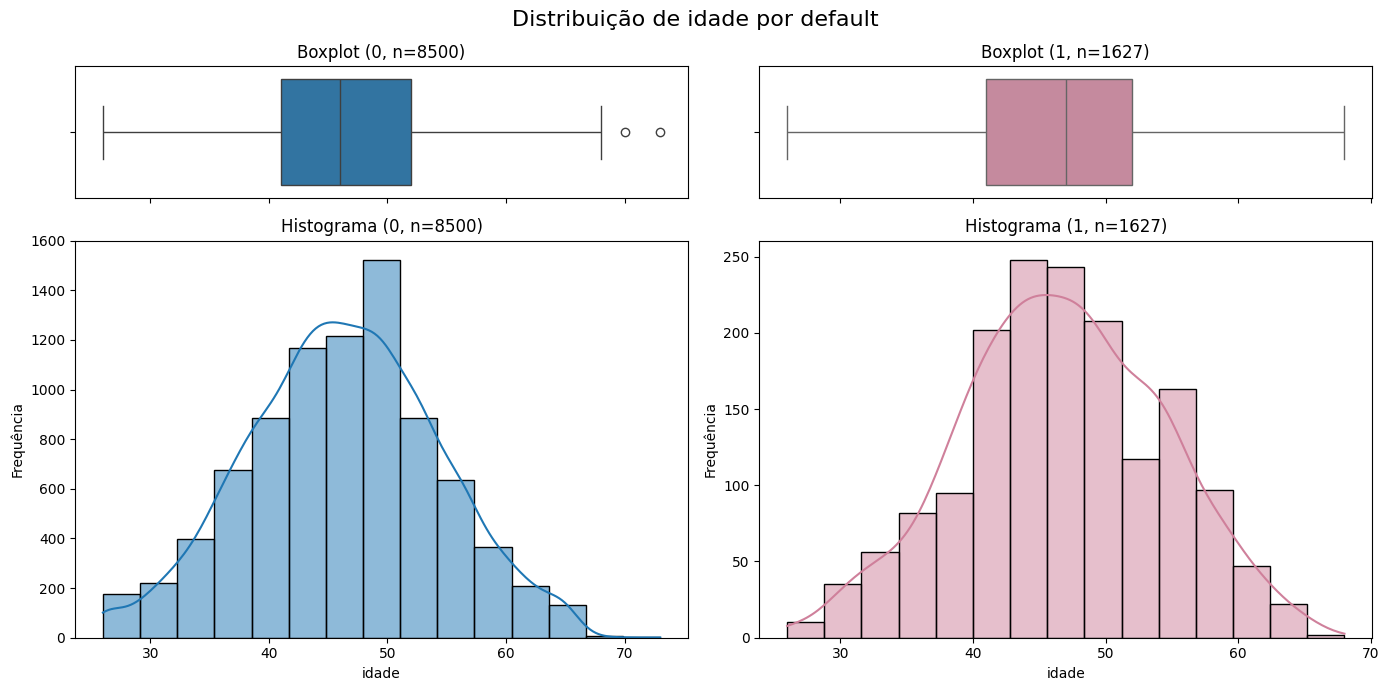

In [5]:
# Distribuição das idades
plotar_distribuicao_agrupada(df, 'idade')

> ✅ **Idade mediana similar**: Ambos os grupos possuem distribuições parecidas

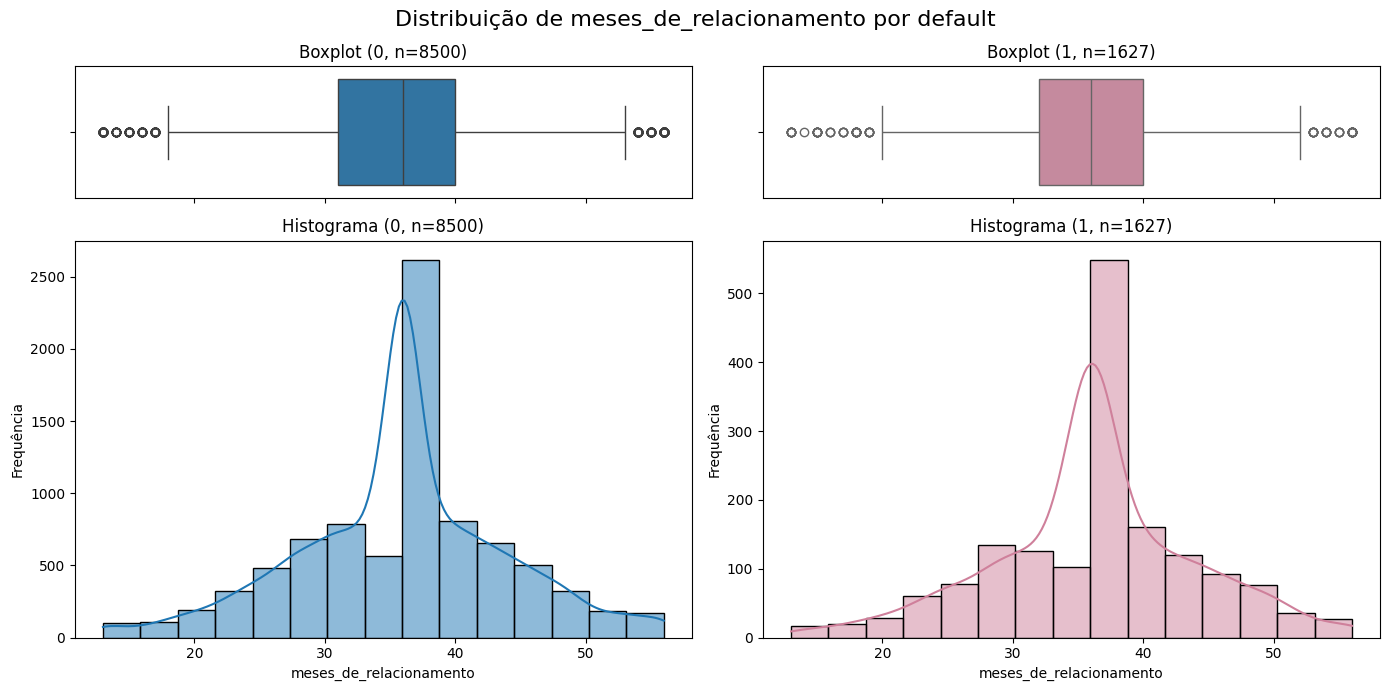

In [6]:
# Distribuição do tempo de relacionamento com a instituição
plotar_distribuicao_agrupada(df, 'meses_de_relacionamento')

> ✅ A distribuição da coluna `meses_de_relacionamento` também tem um comportamento muito parecida entre adimplentes e inadimplentes

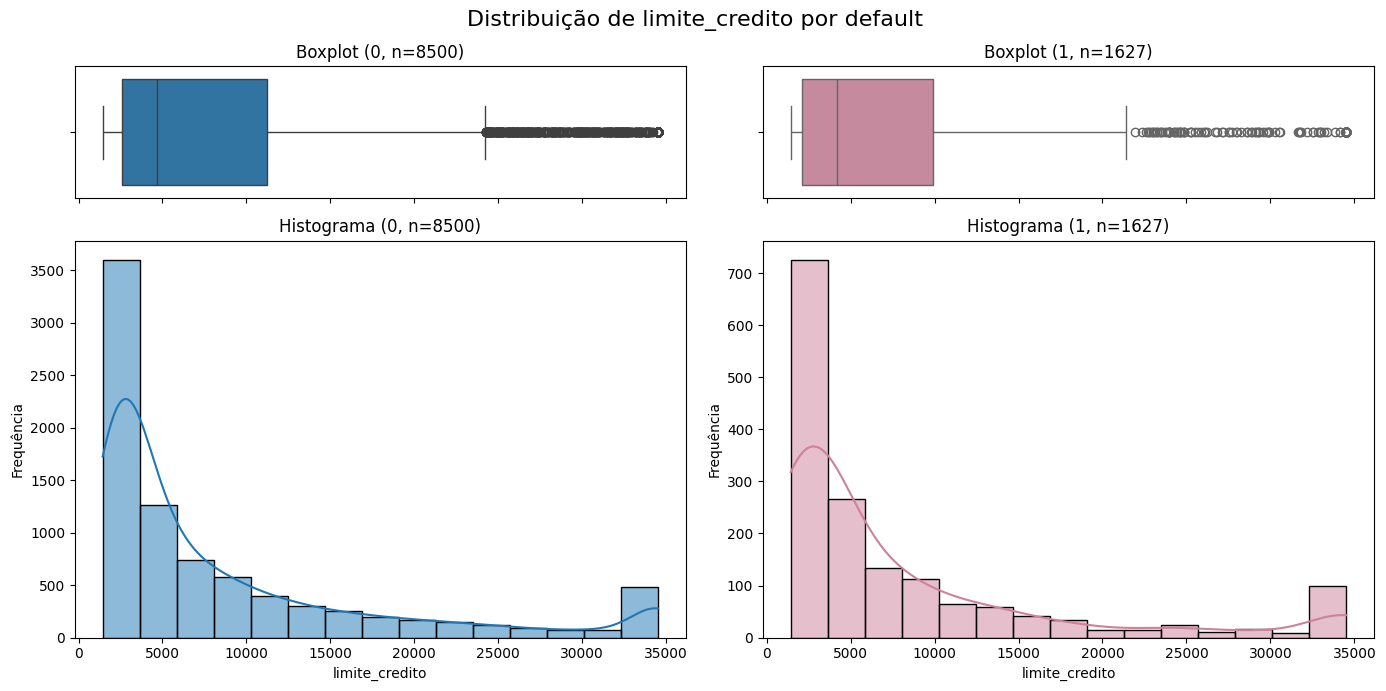

In [7]:
# Distribuição do limite de crédito
plotar_distribuicao_agrupada(df, 'limite_credito')

> ✅ A distribuição da coluna `limite_credito` também é muito parecida entre adimplentes e inadimplentes. Isso pode indicar que ela não seja uma boa variável para explicar a variável `target`

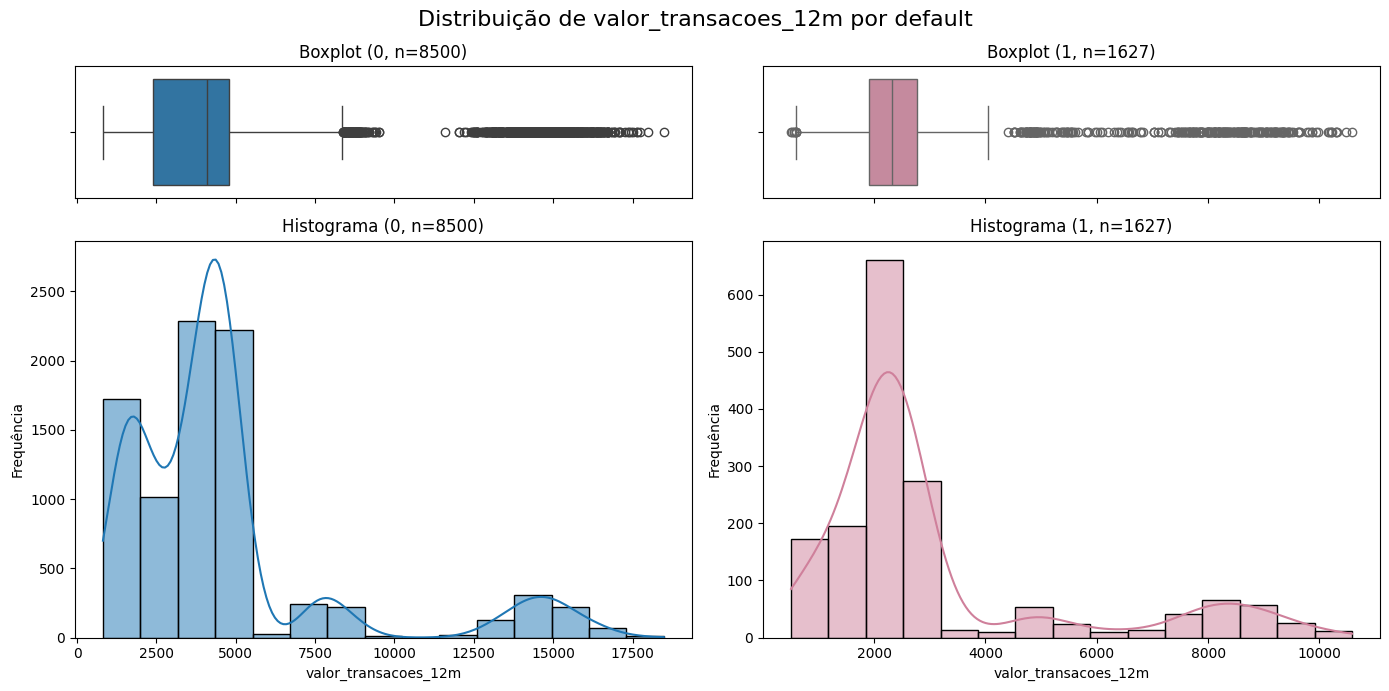

In [8]:
# Distribuição do valor total das transações nos últimos 12 meses
plotar_distribuicao_agrupada(df, 'valor_transacoes_12m')

> 💡 Clientes inadimplentes tendem a ter menores valores transacionados ao longo dos 12 meses, enquanto clientes adimplentes movimentam mais dinheiro. Isso pode sugerir que um maior volume transacionado está relacionado à adimplência, possivelmente porque clientes com maior movimentação financeira possuem mais estabilidade econômica, por exemplo

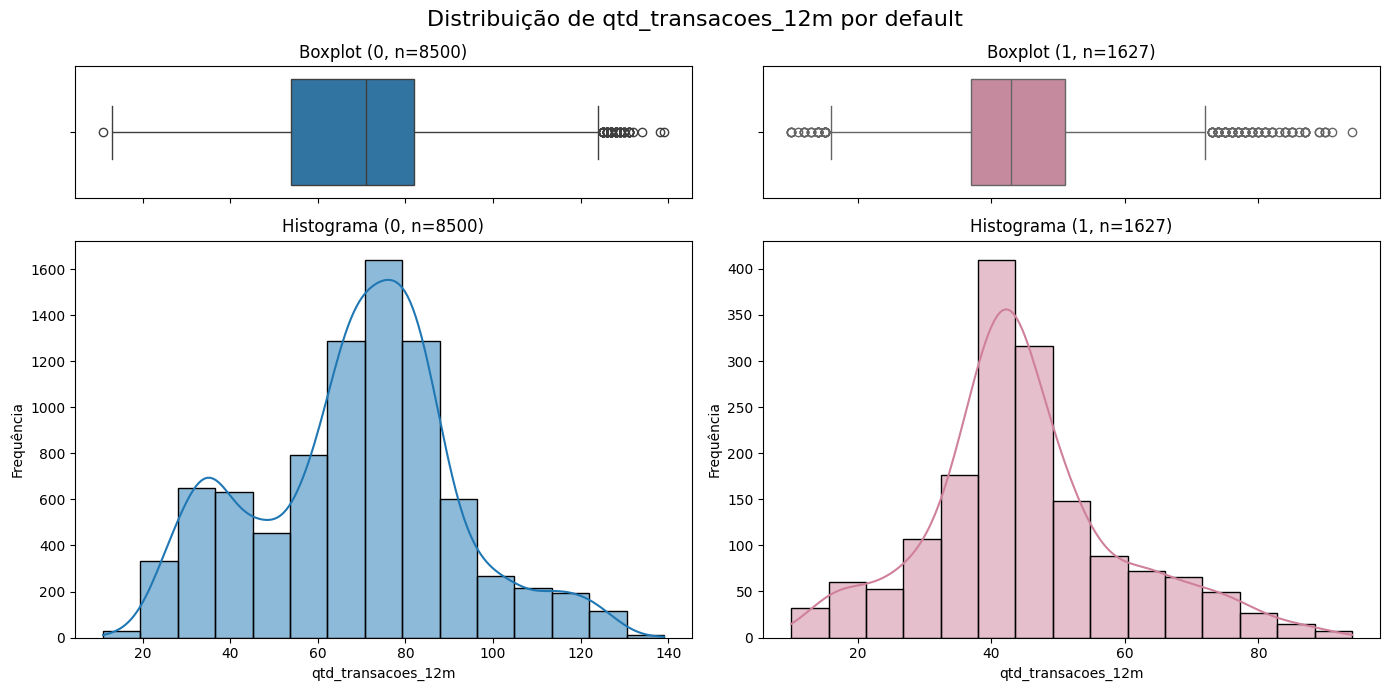

In [9]:
# Distribuição do número de transações nos últimos 12 meses
plotar_distribuicao_agrupada(df, 'qtd_transacoes_12m')

> 💡 Clientes com maior número de transações tendem a ser adimplentes. Isso pode indicar que o uso frequente do cartão está associado a um menor risco de inadimplência, possivelmente porque esses clientes possuem hábitos financeiros mais regulares e previsíveis

### Gráfico de colunas das variáveis categóricas (comparação de adimplentes e inadimplentes)

In [10]:
def plotar_proporcao_categorica_dupla(dados, coluna_categoria, coluna_alvo='default'):
    """
    Gera dois gráficos de colunas lado a lado mostrando as distribuições percentuais
    de uma variável categórica para cada grupo do alvo (adimplente e inadimplente).

    Parâmetros:
    - dados: DataFrame contendo os dados.
    - coluna_categoria: Coluna categórica a ser analisada.
    - coluna_alvo: Nome da coluna de agrupamento (padrão: 'default').
    """

    # Criar tabela de contingência com percentual dentro de cada grupo do alvo
    tabela = pd.crosstab(dados[coluna_alvo], dados[coluna_categoria], normalize=0) * 100

    # Definir cores para cada grupo
    cores = {0: '#1F77B4', 1: '#CF809B'}  # Azul para adimplentes, Rosa para inadimplentes

    # Criar a figura com 2 gráficos lado a lado
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

    for i, grupo in enumerate(sorted(tabela.index)):  # Ordena para garantir consistência (0 antes de 1)
        ax = axes[i]

        sns.barplot(x=tabela.columns, y=tabela.loc[grupo], color=cores[grupo], ax=ax)

        ax.set_title(f"Distribuição de '{coluna_categoria}' para Default = {grupo}", fontsize=14)
        ax.set_xlabel(coluna_categoria)
        ax.set_ylabel("Proporção (%)" if i == 0 else "")

        # Ajustar os ticks corretamente antes de rotacionar os rótulos
        ax.set_xticks(range(len(tabela.columns)))
        ax.set_xticklabels(tabela.columns, rotation=45)

        # Adicionar rótulos de porcentagem sobre as barras
        for p, valor in zip(ax.patches, tabela.loc[grupo]):
            ax.annotate(f"{valor:.1f}%",
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='bottom', fontsize=10, color='black')

    plt.tight_layout()
    plt.show()

In [11]:
print("\n📊 Tabela de contingência (% dentro de cada grupo) para Escolaridade:")
display(pd.crosstab(df['escolaridade'], df['default'], normalize='columns').T * 100)


📊 Tabela de contingência (% dentro de cada grupo) para Escolaridade:


escolaridade,doutorado,ensino medio,graduacao,mestrado,sem educacao formal
default,,,,,
0,10.777947,23.587122,11.869559,36.493022,17.272350
1,13.639679,22.319475,11.232677,35.521517,17.286652


> 💡 Usar o percentual de inadimplentes versus adimplentes dentro de uma determinada categoria é um caminho melhor, pois muitos desses grupos estão desbalanceados. Portanto, olhar para o valor bruto poderia trazer informações erradas acerca dos dados

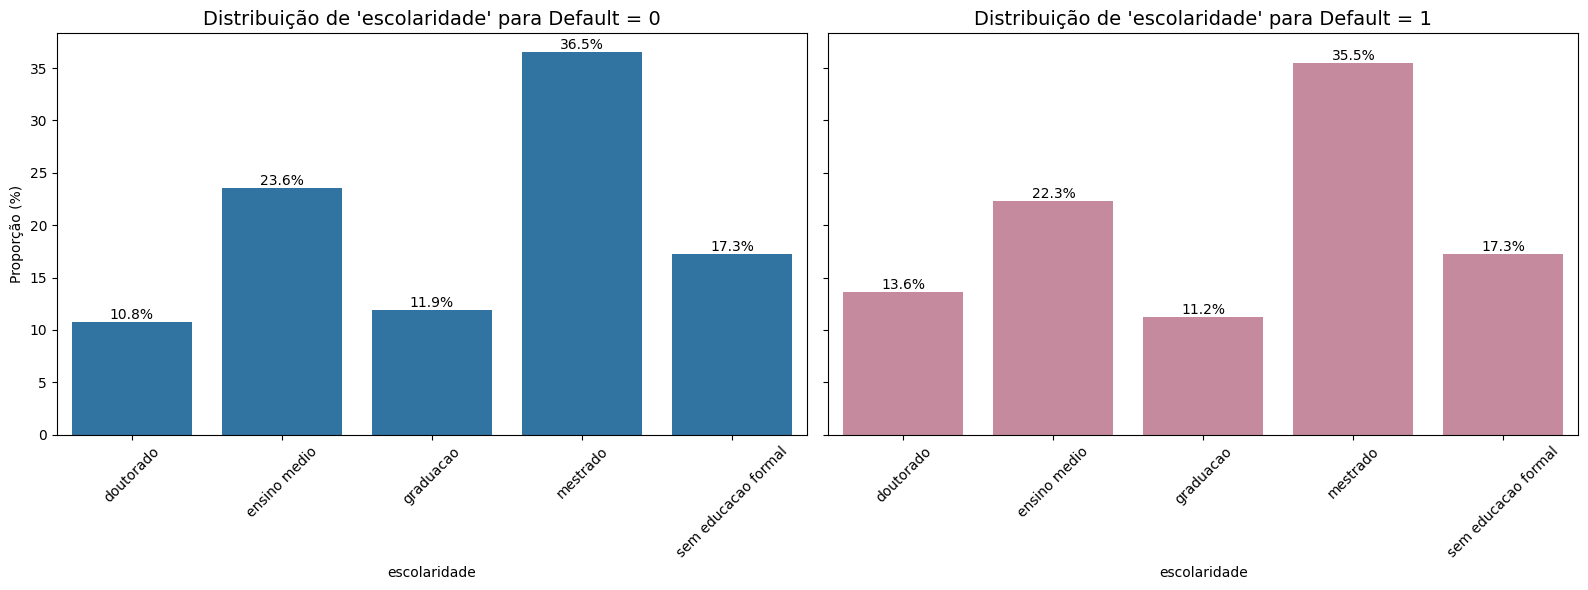

In [12]:
# 🔹 Plotando gráfico de proporção para Escolaridade
plotar_proporcao_categorica_dupla(df, 'escolaridade')

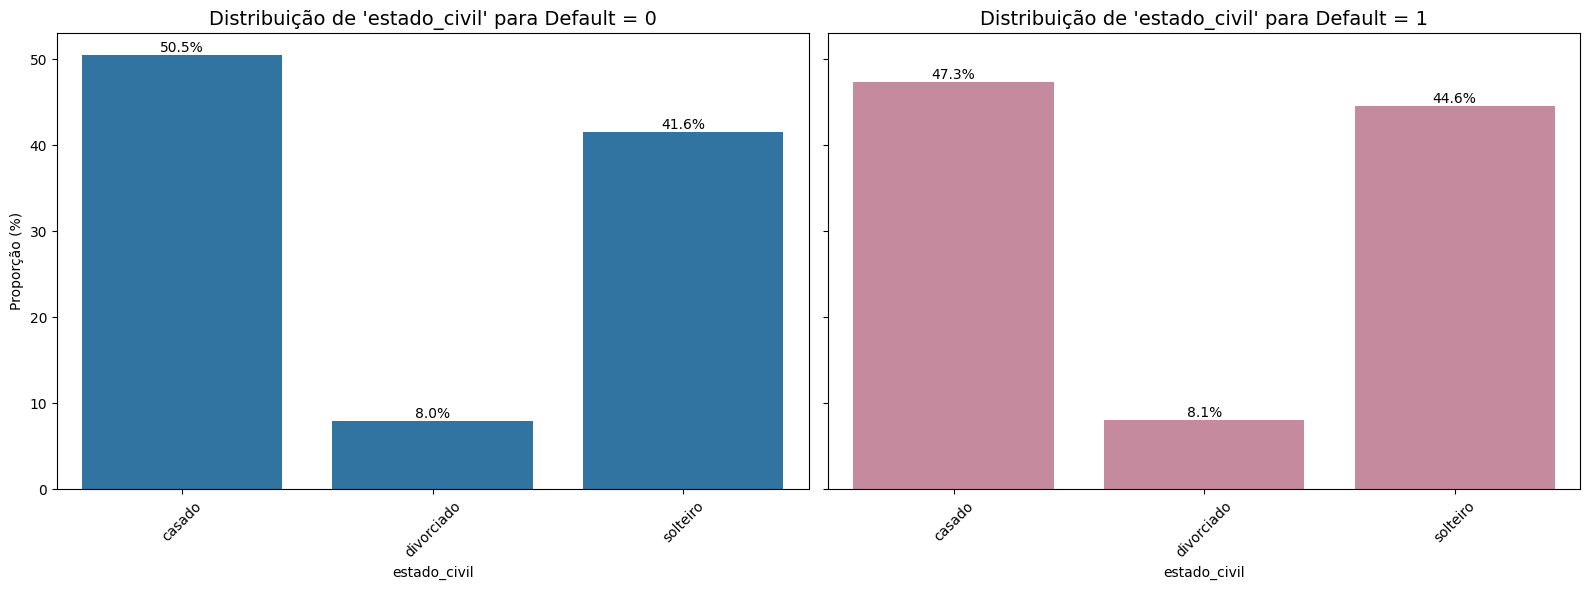

In [13]:
# 🔹 Plotando gráfico de proporção para Estado Civil
plotar_proporcao_categorica_dupla(df, 'estado_civil')

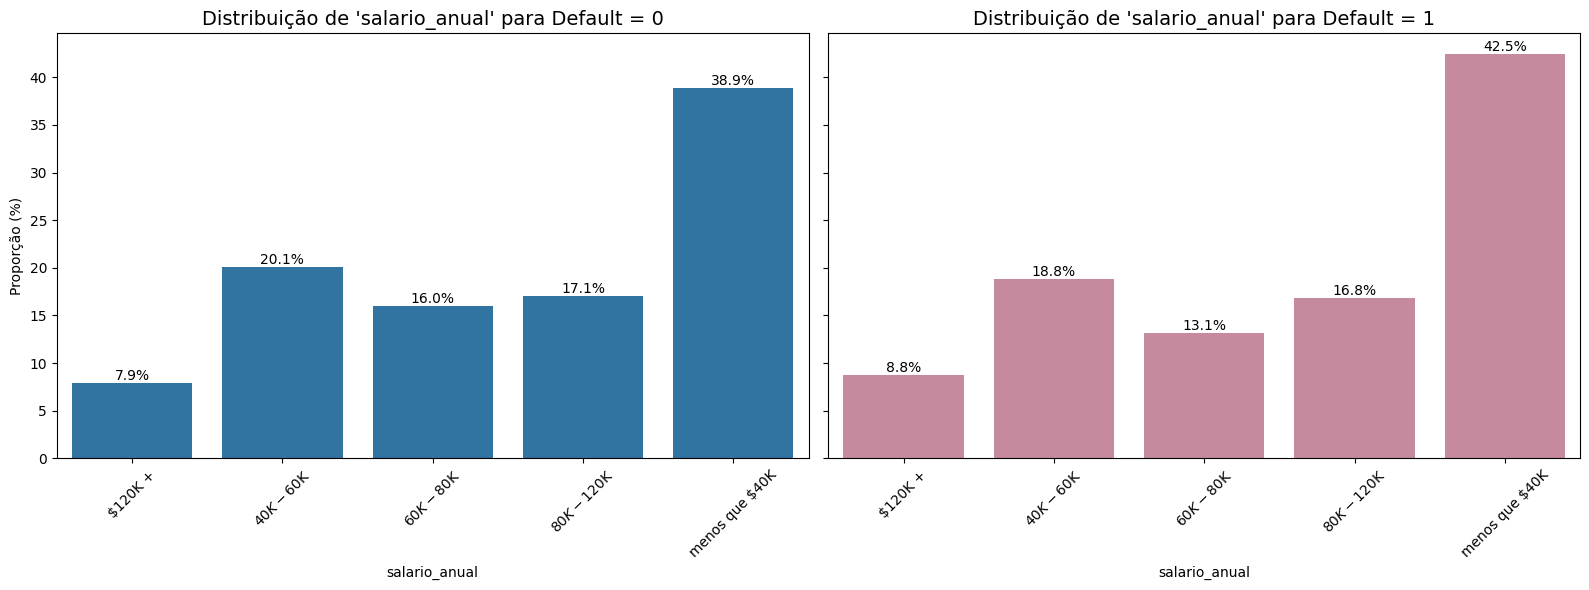

In [14]:
# 📌 Analisando a relação entre faixa salarial e inadimplência
plotar_proporcao_categorica_dupla(df, 'salario_anual')

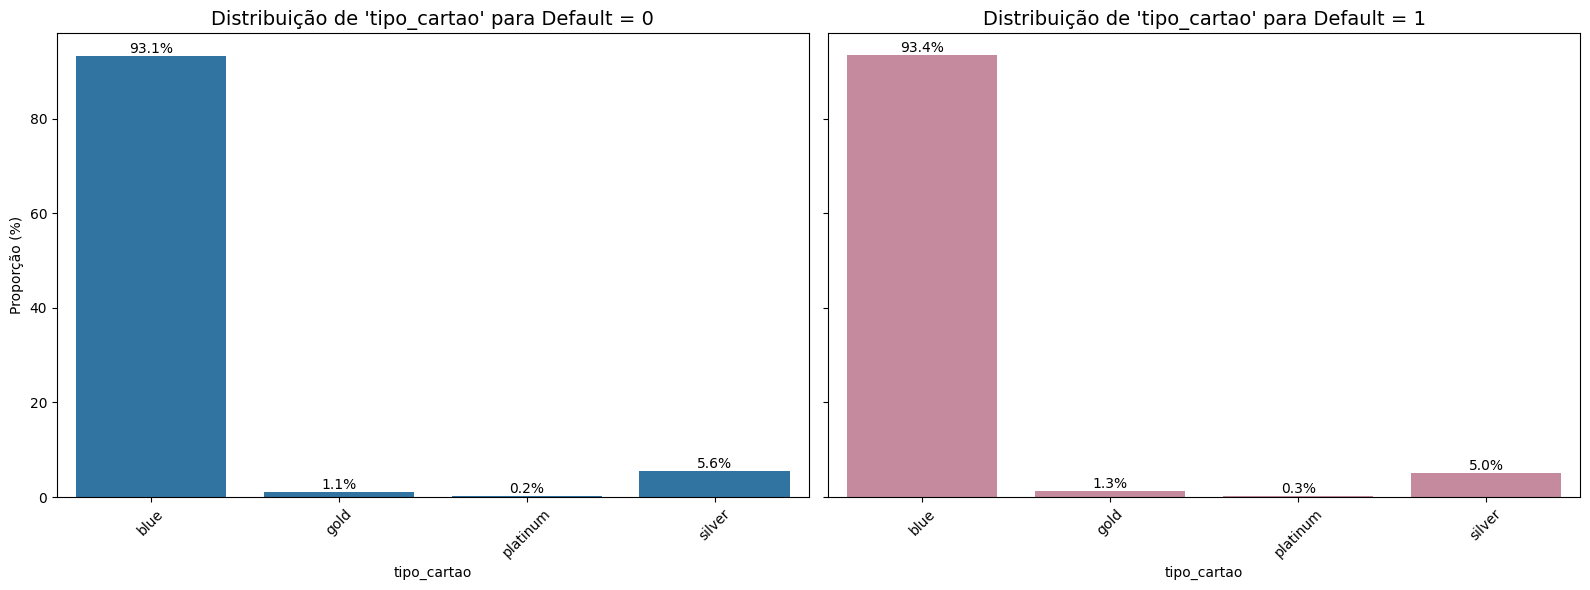

In [15]:
# 📌 Analisando a relação entre tipo de cartão e inadimplência
plotar_proporcao_categorica_dupla(df, 'tipo_cartao')

> A grande maioria dos clientes, tanto inadimplentes quanto adimplentes, possuem o cartão Blue (`~93%`). Isso pode indicar que a oferta desse cartão é muito maior em relação aos outros, sendo o mais comum no portfólio da instituição.

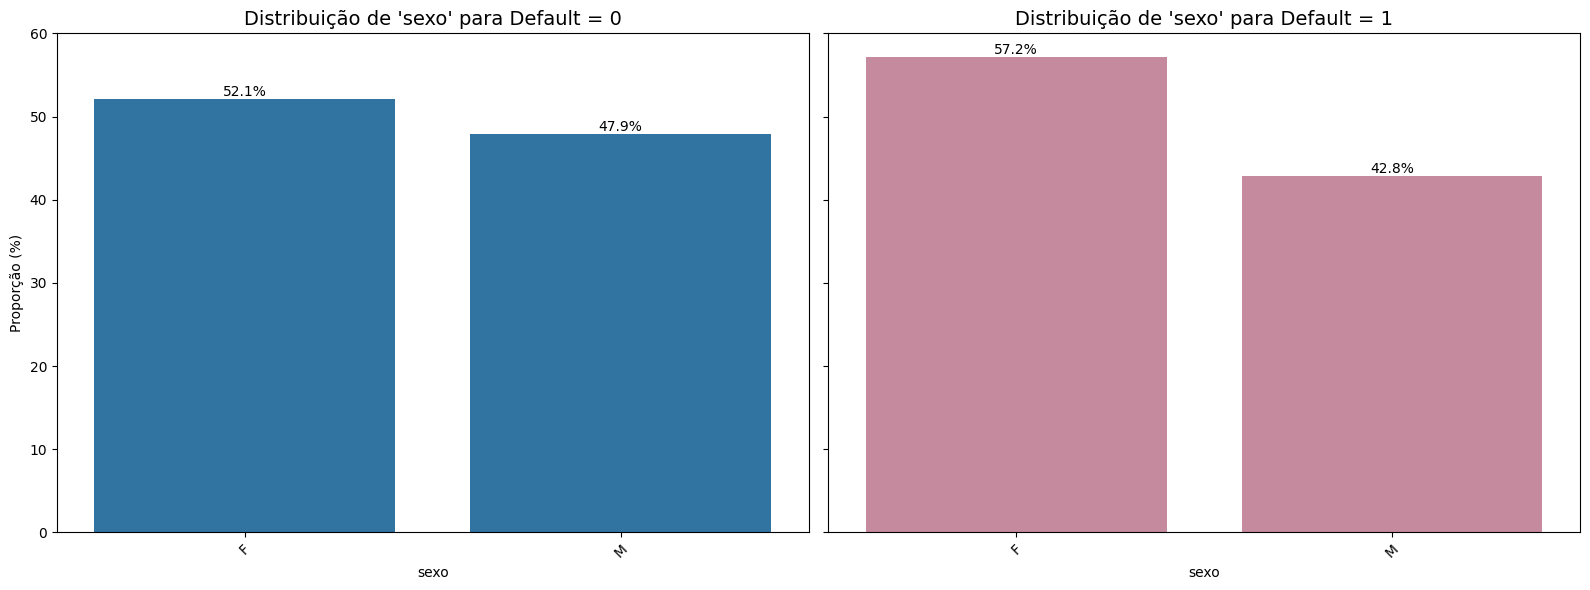

In [16]:
# Proporções agrupadas por Gênero
plotar_proporcao_categorica_dupla(df, 'sexo')

> A inadimplência é um pouco mais comum entre mulheres, já que elas compõem uma proporção maior do grupo de `default = 1` em comparação com `default = 0`.

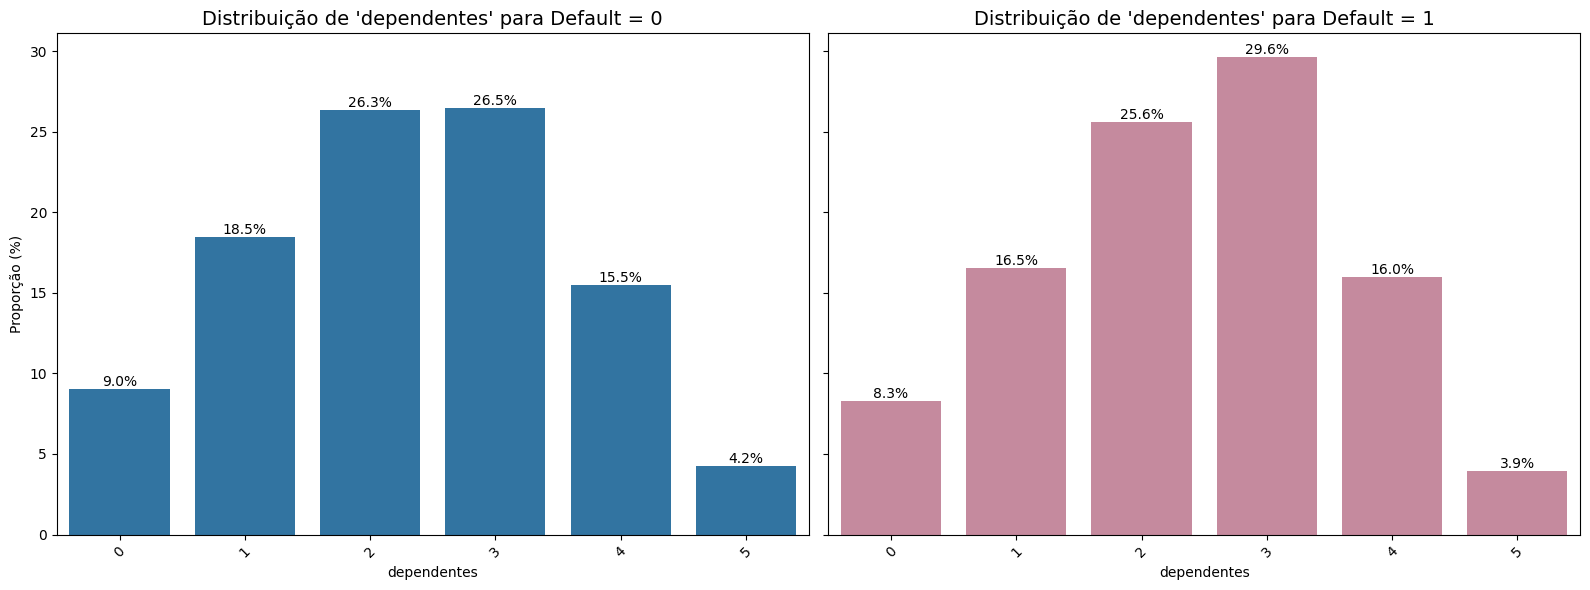

In [17]:
# Proporções agrupadas por Número de Dependentes
plotar_proporcao_categorica_dupla(df, 'dependentes')

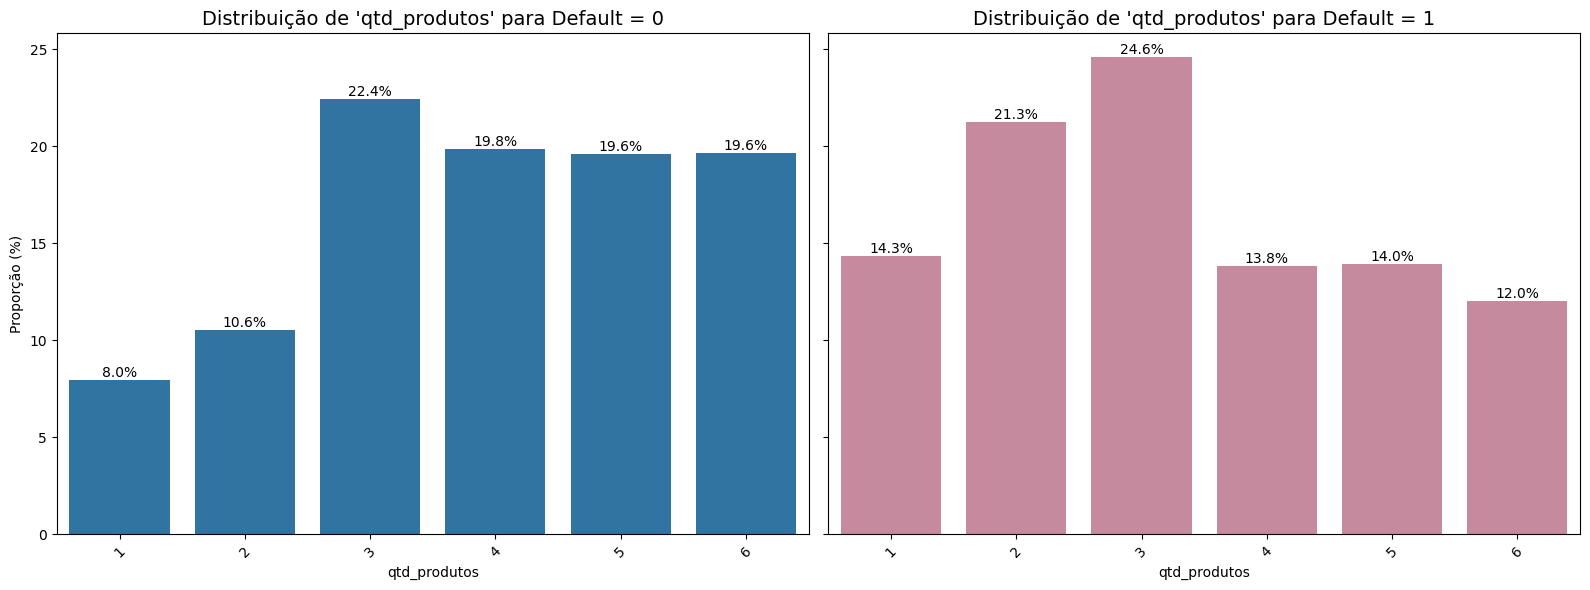

In [18]:
# Proporções agrupadas por Quantidade de Produtos
plotar_proporcao_categorica_dupla(df, 'qtd_produtos')

> No grupo inadimplente, as categorias 4, 5 e 6 produtos têm menores proporções em comparação com os adimplentes, o que pode indicar que clientes que possuem mais produtos financeiros estão menos propensos à inadimplência.

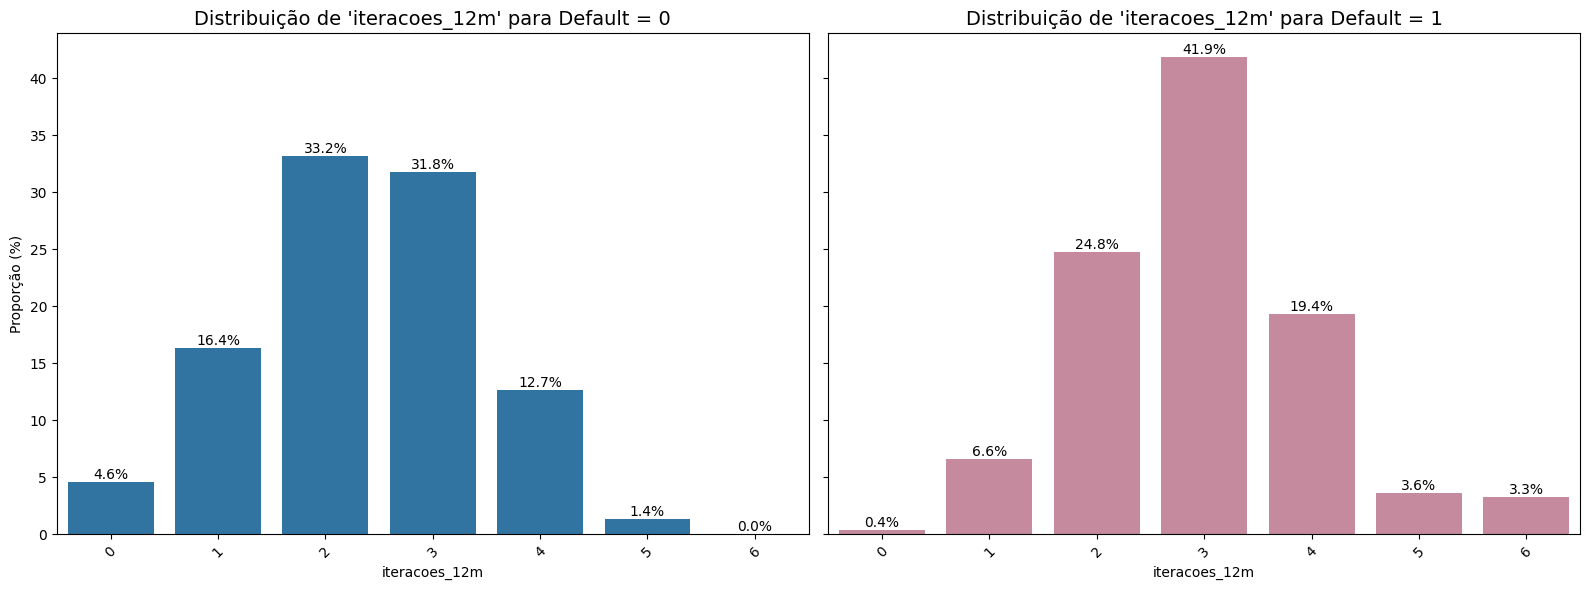

In [19]:
# Proporções agrupadas por Número de Interações nos últimos 12 meses
plotar_proporcao_categorica_dupla(df, 'iteracoes_12m')

> No grupo inadimplente, 41.9% dos clientes tiveram exatamente 3 interações, enquanto no grupo adimplente, essa proporção foi menor (31.8%).

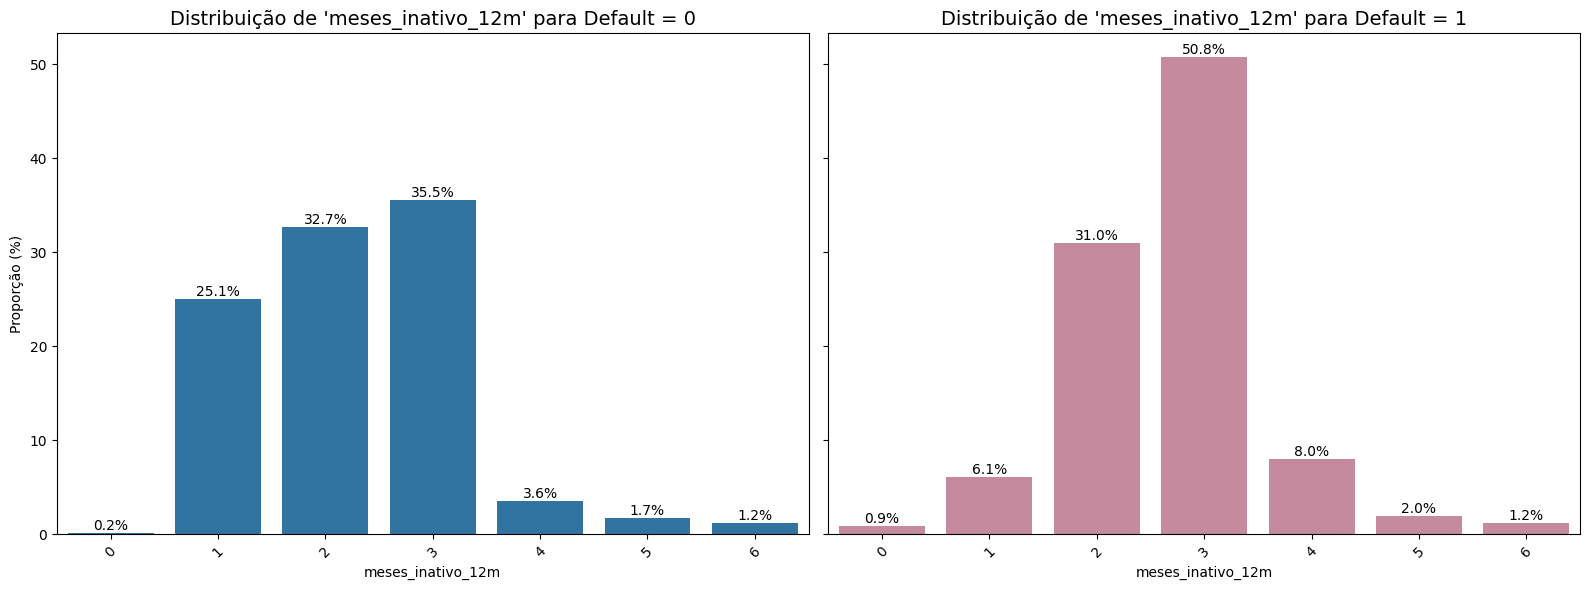

In [20]:
# Proporções agrupadas por Meses Inativo nos últimos 12 meses
plotar_proporcao_categorica_dupla(df, 'meses_inativo_12m')

> 50.8% dos inadimplentes ficaram inativos por 3 meses, enquanto no grupo adimplente essa proporção foi de 35.5%. Isso sugere que **ficar inativo por longos períodos pode ser um indicativo de risco de inadimplência**.

### Análises multivariadas (gráfico de dispersão com hue)

In [21]:
def grafico_dispersao(dados, x_col, y_col, hue_col='default', alpha=0.6, escala_log=False):
    """
    Plota um gráfico de dispersão entre duas variáveis, diferenciando os pontos por uma variável categórica.

    Parâmetros:
    - dados: DataFrame contendo os dados.
    - x_col: Nome da coluna para o eixo X.
    - y_col: Nome da coluna para o eixo Y.
    - hue_col: Coluna categórica para diferenciação das cores (padrão: 'default' - inadimplência).
    - alpha: Transparência dos pontos (padrão: 0.6).
    - escala_log: Se True, aplica escala logarítmica para melhor visualização de dispersões grandes.
    """
    plt.figure(figsize=(10, 6))

    # Definir paleta de cores mais contrastante
    paleta = {0: '#1F77B4', 1: '#D62728'}  # Azul para adimplentes, Vermelho para inadimplentes

    # Criar scatterplot com categorização por cor
    scatter = sns.scatterplot(
        data=dados, x=x_col, y=y_col, hue=hue_col, palette=paleta, alpha=alpha
    )

    plt.title(f'Gráfico de Dispersão: {x_col} vs {y_col}', fontsize=14)
    plt.xlabel(x_col, fontsize=12)
    plt.ylabel(y_col, fontsize=12)
    plt.legend(title=hue_col, bbox_to_anchor=(1.05, 1), loc='upper left')

    # Aplicar escala logarítmica se necessário
    if escala_log:
        plt.xscale('log')
        plt.yscale('log')

    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

1️⃣ Limite de Crédito vs. Valor Total das Transações
- Hipótese: Clientes com maior limite de crédito realizam transações de maior valor?

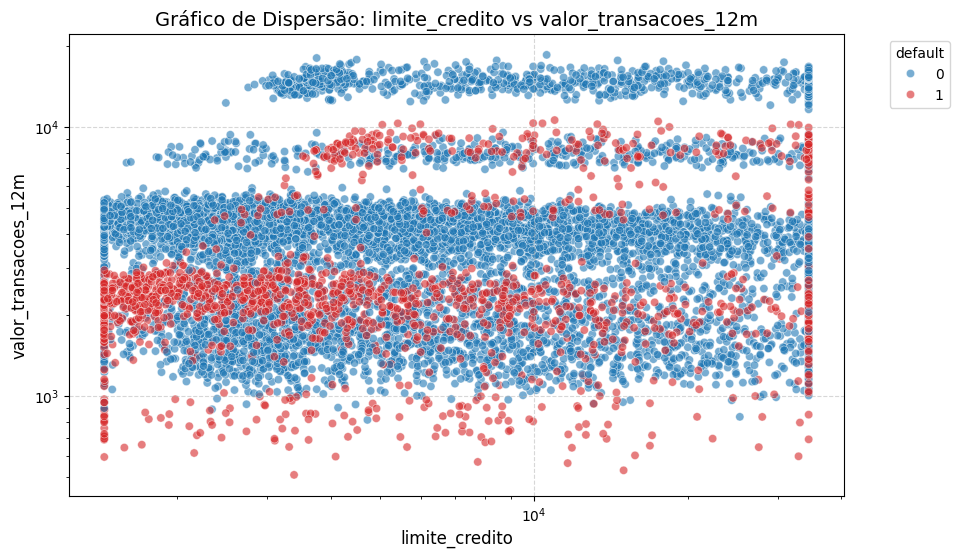

In [22]:
grafico_dispersao(df, 'limite_credito', 'valor_transacoes_12m', escala_log=True)

> Existe uma tendência crescente: clientes com limite de crédito mais alto (direita do gráfico) realizam transações de valores mais altos.
Isso faz sentido, pois um maior limite de crédito permite transações mais volumosas.

> Muitos inadimplentes realizam transações de valores menores, **mesmo quando possuem limite de crédito relativamente alto**.
Isso pode indicar que clientes inadimplentes não utilizam todo o crédito disponível ou têm dificuldades em movimentar grandes quantias.

2️⃣ Limite de Crédito vs. Quantidade de Transações
- Hipótese: Quanto maior o limite de crédito, mais transações são realizadas?

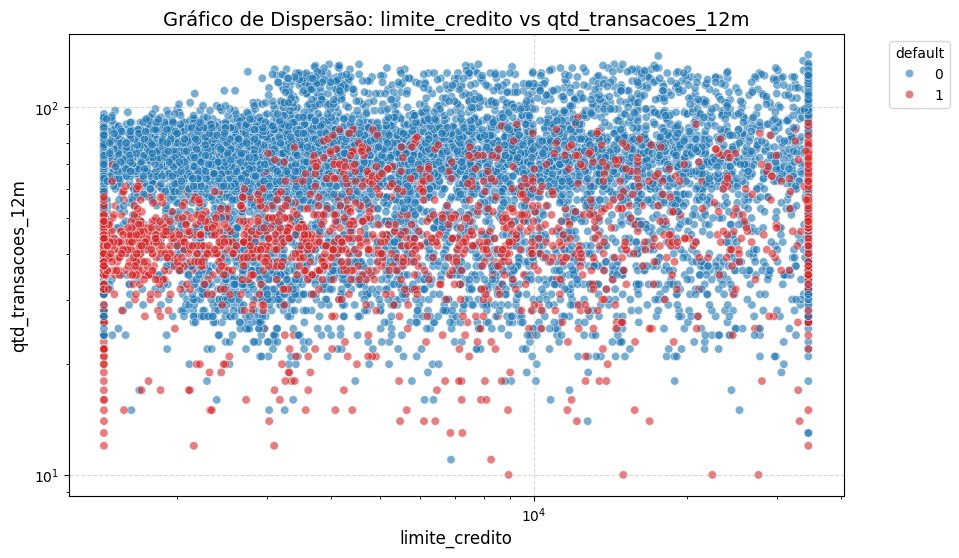

In [23]:
grafico_dispersao(df, 'limite_credito', 'qtd_transacoes_12m', escala_log=True)

> Há uma concentração maior de inadimplentes na parte inferior do gráfico (menos transações). Isso pode sugerir que clientes inadimplentes usam o cartão com menor frequência ou fazem transações menos recorrentes.

> Outra hipótese é que **clientes que usam o cartão com menos frequência têm maior probabilidade de inadimplência**, o que pode estar relacionado à falta de controle financeiro ou uso do crédito em situações pontuais.

3️⃣ Valor Total das Transações vs. Quantidade de Transações
- Hipótese: Existe um padrão de gastos entre os clientes que fazem mais ou menos transações?

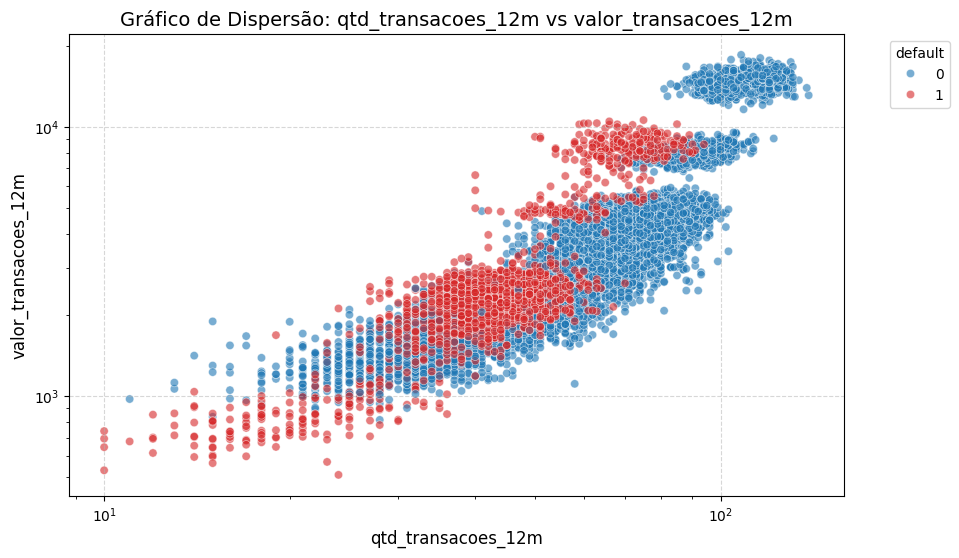

In [24]:
grafico_dispersao(df, 'qtd_transacoes_12m', 'valor_transacoes_12m', escala_log=True)

> Muitos clientes inadimplentes estão na parte intermediária do gráfico, com um número razoável de transações, mas valores movimentados mais baixos. Isso sugere que **clientes inadimplentes fazem transações frequentes, mas não movimentam tanto dinheiro quanto os adimplentes**.

## 6️⃣ Preparação dos dados para a modelagem

### Divisão dos dados usando `stratified sampling`

In [25]:
from sklearn.model_selection import train_test_split

def dividir_dados(df, target='default', test_size=0.2, random_state=1234):
    """
    Divide os dados de forma estratificada, garantindo que a distribuição da variável alvo seja preservada.

    Parâmetros:
    - df: DataFrame contendo os dados.
    - target: Nome da variável alvo.
    - test_size: Proporção do conjunto de teste (padrão: 20%).
    - random_state: Semente para reprodutibilidade (padrão: 1234).

    Retorna:
    - df_treino: DataFrame de treino.
    - df_teste: DataFrame de teste.
    """
    if target not in df.columns:
        raise ValueError(f"A coluna '{target}' não foi encontrada no DataFrame.")

    X = df.drop(columns=[target])
    y = df[target]

    X_treino, X_teste, y_treino, y_teste = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # Reconstruindo os DataFrames com a variável target
    df_treino = X_treino.assign(**{target: y_treino})
    df_teste = X_teste.assign(**{target: y_teste})

    return df_treino, df_teste

df_treino, df_teste = dividir_dados(df, target='default')

In [26]:
# 🔹 Confirmação de que o `stratify` manteve a proporção da variável alvo
print("Distribuição no conjunto de treino:")
print(df_treino['default'].value_counts(normalize=True) * 100)

print("\nDistribuição no conjunto de teste:")
print(df_teste['default'].value_counts(normalize=True) * 100)

Distribuição no conjunto de treino:
default
0    83.92791
1    16.07209
Name: proportion, dtype: float64

Distribuição no conjunto de teste:
default
0    83.958539
1    16.041461
Name: proportion, dtype: float64


In [27]:
# 🔹 Verificação da estrutura dos DataFrames após a divisão
print("\nInformações do conjunto de treino:")
df_treino.info()

print("\nInformações do conjunto de teste:")
df_teste.info()


Informações do conjunto de treino:
<class 'pandas.core.frame.DataFrame'>
Index: 8101 entries, 3307 to 4858
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   idade                    8101 non-null   int64  
 1   sexo                     8101 non-null   object 
 2   dependentes              8101 non-null   int64  
 3   escolaridade             6892 non-null   object 
 4   estado_civil             7517 non-null   object 
 5   salario_anual            7213 non-null   object 
 6   tipo_cartao              8101 non-null   object 
 7   meses_de_relacionamento  8101 non-null   int64  
 8   qtd_produtos             8101 non-null   int64  
 9   iteracoes_12m            8101 non-null   int64  
 10  meses_inativo_12m        8101 non-null   int64  
 11  limite_credito           8101 non-null   float64
 12  valor_transacoes_12m     8101 non-null   float64
 13  qtd_transacoes_12m       8101 non-null   int

### Preenchimento dos valores nulos

In [28]:
# --- FUNÇÃO PARA PREENCHER VALORES NULOS ---
def preencher_nulos(df):
    """
    Preenche valores nulos nas colunas categóricas com a moda da respectiva coluna.

    Parâmetros:
    - df: DataFrame a ser processado.

    Retorna:
    - df preenchido sem modificar o original.
    """
    df_preenchido = df.copy()
    colunas_categoricas = df_preenchido.select_dtypes(include=['object']).columns

    for coluna in colunas_categoricas:
        if df_preenchido[coluna].isnull().sum() > 0:
            df_preenchido[coluna] = df_preenchido[coluna].fillna(df_preenchido[coluna].mode()[0])

    return df_preenchido

# Aplicar a função nos conjuntos de treino e teste
df_treino = preencher_nulos(df_treino)
df_teste = preencher_nulos(df_teste)

In [29]:
# 🔹 Verificação final
print("\nInformações após tratamento de valores nulos (Teste):")
df_teste.info()


Informações após tratamento de valores nulos (Teste):
<class 'pandas.core.frame.DataFrame'>
Index: 2026 entries, 2266 to 3630
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   idade                    2026 non-null   int64  
 1   sexo                     2026 non-null   object 
 2   dependentes              2026 non-null   int64  
 3   escolaridade             2026 non-null   object 
 4   estado_civil             2026 non-null   object 
 5   salario_anual            2026 non-null   object 
 6   tipo_cartao              2026 non-null   object 
 7   meses_de_relacionamento  2026 non-null   int64  
 8   qtd_produtos             2026 non-null   int64  
 9   iteracoes_12m            2026 non-null   int64  
 10  meses_inativo_12m        2026 non-null   int64  
 11  limite_credito           2026 non-null   float64
 12  valor_transacoes_12m     2026 non-null   float64
 13  qtd_transacoes_12m       

### Pré-processamento

In [30]:
# --- PRÉ-PROCESSAMENTO ---
def preprocessar_dados(dados):
    """
    Aplica transformações de variáveis categóricas e imputação de valores ausentes.

    Parâmetros:
    - dados: DataFrame original.

    Retorna:
    - DataFrame transformado.
    """
    dados = dados.copy()

    # Mapeamentos de label encoding para variáveis ordinais
    mapeamentos = {
        'salario_anual': {'menos que $40K': 1, '$40K - $60K': 2, '$60K - $80K': 3, '$80K - $120K': 4, '$120K +': 5},
        'escolaridade': {'sem educacao formal': 1, 'ensino medio': 2, 'graduacao': 3, 'mestrado': 4, 'doutorado': 5},
        'tipo_cartao': {'blue': 1, 'silver': 2, 'gold': 3, 'platinum': 4}
    }

    # Aplicar os mapeamentos apenas se as colunas existirem
    for coluna, mapa in mapeamentos.items():
        if coluna in dados.columns:
            dados[coluna] = dados[coluna].map(mapa)

    # One-Hot Encoding para variáveis nominais, se existirem
    colunas_categoricas = ['estado_civil', 'sexo']
    colunas_categoricas_existentes = [col for col in colunas_categoricas if col in dados.columns]

    if colunas_categoricas_existentes:
        dados = pd.get_dummies(dados, columns=colunas_categoricas_existentes, drop_first=True, dtype=int)

    return dados

# Aplicar pré-processamento nos conjuntos de treino e teste
df_treino_transf = preprocessar_dados(df_treino)
df_teste_transf = preprocessar_dados(df_teste)

In [31]:
# 🔹 Verificação após transformação
print("\n📌 Informações do conjunto de treino pós-transformação:")
df_treino_transf.info()


📌 Informações do conjunto de treino pós-transformação:
<class 'pandas.core.frame.DataFrame'>
Index: 8101 entries, 3307 to 4858
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   idade                    8101 non-null   int64  
 1   dependentes              8101 non-null   int64  
 2   escolaridade             8101 non-null   int64  
 3   salario_anual            8101 non-null   int64  
 4   tipo_cartao              8101 non-null   int64  
 5   meses_de_relacionamento  8101 non-null   int64  
 6   qtd_produtos             8101 non-null   int64  
 7   iteracoes_12m            8101 non-null   int64  
 8   meses_inativo_12m        8101 non-null   int64  
 9   limite_credito           8101 non-null   float64
 10  valor_transacoes_12m     8101 non-null   float64
 11  qtd_transacoes_12m       8101 non-null   int64  
 12  default                  8101 non-null   int64  
 13  estado_civil_divorciado 

In [32]:
print("\n📌 Informações do conjunto de teste pós-transformação:")
df_teste_transf.info()


📌 Informações do conjunto de teste pós-transformação:
<class 'pandas.core.frame.DataFrame'>
Index: 2026 entries, 2266 to 3630
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   idade                    2026 non-null   int64  
 1   dependentes              2026 non-null   int64  
 2   escolaridade             2026 non-null   int64  
 3   salario_anual            2026 non-null   int64  
 4   tipo_cartao              2026 non-null   int64  
 5   meses_de_relacionamento  2026 non-null   int64  
 6   qtd_produtos             2026 non-null   int64  
 7   iteracoes_12m            2026 non-null   int64  
 8   meses_inativo_12m        2026 non-null   int64  
 9   limite_credito           2026 non-null   float64
 10  valor_transacoes_12m     2026 non-null   float64
 11  qtd_transacoes_12m       2026 non-null   int64  
 12  default                  2026 non-null   int64  
 13  estado_civil_divorciado  

### Matriz de correlação

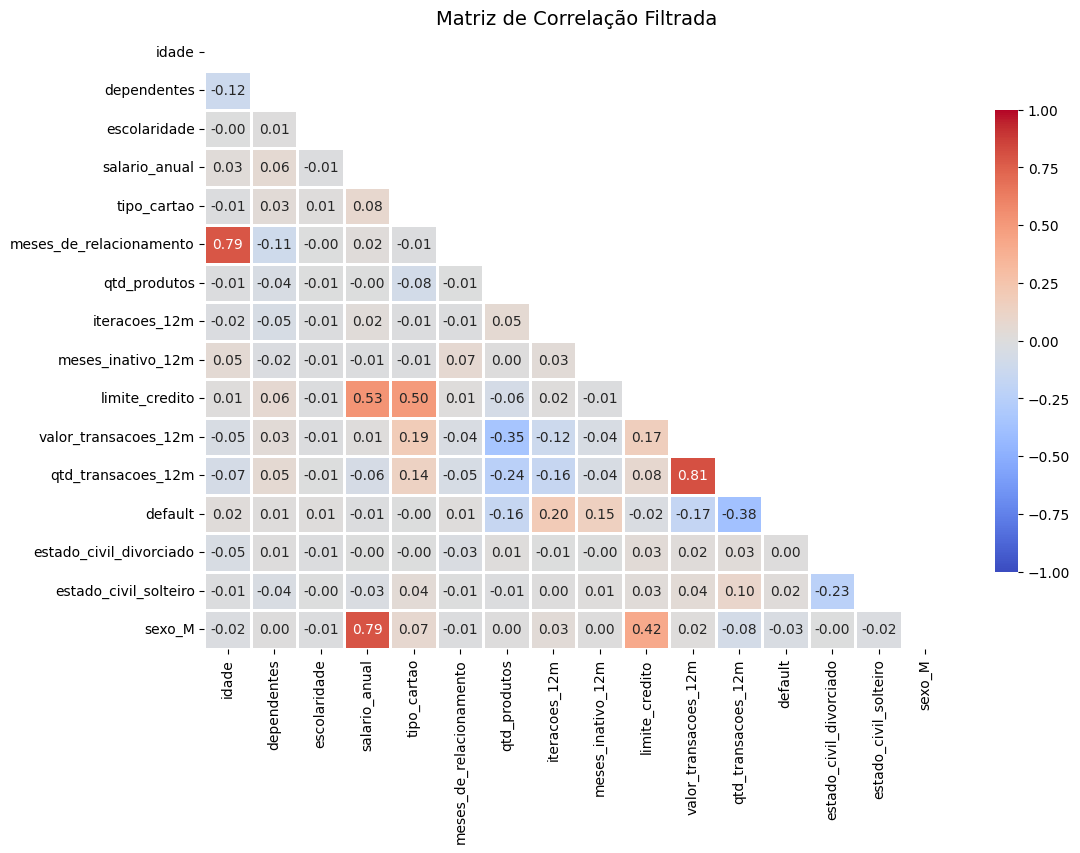

In [33]:
# --- MATRIZ DE CORRELAÇÃO ---
def plot_matriz_correlacao(df, threshold=0.3):
    """
    Plota a matriz de correlação, destacando apenas os valores acima do threshold.

    Parâmetros:
    - df: DataFrame contendo os dados numéricos.
    - threshold: Valor mínimo absoluto para exibir anotações.

    Retorno:
    - Heatmap da matriz de correlação.
    """
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))

    plt.figure(figsize=(12, 8))
    sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", center=0,
                linewidths=1, cbar_kws={'shrink': 0.75}, annot_kws={"size": 10},
                vmin=-1, vmax=1)

    plt.title("Matriz de Correlação Filtrada", fontsize=14)
    plt.show()

# Chamando a função
plot_matriz_correlacao(df_treino_transf)

### Separação das variáveis explicativas e alvo

In [34]:
# --- SEPARAÇÃO DAS VARIÁVEIS EXPLICATIVAS E ALVO ---
def separar_variaveis(df_treino, df_teste, alvo='default'):
    """
    Separa as variáveis explicativas (X) e a variável alvo (y) nos conjuntos de treino e teste.

    Parâmetros:
    - df_treino: DataFrame de treino pré-processado.
    - df_teste: DataFrame de teste pré-processado.
    - alvo: Nome da coluna alvo.

    Retorna:
    - X_treino, y_treino, X_teste, y_teste
    """
    X_treino = df_treino.drop(columns=[alvo])
    y_treino = df_treino[alvo]

    X_teste = df_teste.drop(columns=[alvo])
    y_teste = df_teste[alvo]

    # Exibir informações sobre os conjuntos de dados
    print("\n📌 Tamanho dos conjuntos de treino e teste:")
    print(f"  - X_treino: {X_treino.shape}, y_treino: {y_treino.shape}")
    print(f"  - X_teste: {X_teste.shape}, y_teste: {y_teste.shape}")

    return X_treino, y_treino, X_teste, y_teste

# 🔹 Aplicando a separação das variáveis
X_treino, y_treino, X_teste, y_teste = separar_variaveis(df_treino_transf, df_teste_transf)


📌 Tamanho dos conjuntos de treino e teste:
  - X_treino: (8101, 15), y_treino: (8101,)
  - X_teste: (2026, 15), y_teste: (2026,)


In [35]:
# 🔹 Conferindo as primeiras linhas
print("\n🔹 Amostra de X_treino:")
display(X_treino.head(2))

print("\n🔹 Amostra de y_treino:")
display(y_treino.head(2))

print("\n🔹 Amostra de X_teste:")
display(X_teste.head(2))

print("\n🔹 Amostra de y_teste:")
display(y_teste.head(2))


🔹 Amostra de X_treino:


,idade,dependentes,escolaridade,salario_anual,tipo_cartao,meses_de_relacionamento,qtd_produtos,iteracoes_12m,meses_inativo_12m,limite_credito,valor_transacoes_12m,qtd_transacoes_12m,estado_civil_divorciado,estado_civil_solteiro,sexo_M
3307,41,4,2,4,1,29,4,1,2,12154.32,3853.80,71,0,0,1
3355,51,1,1,3,1,44,4,3,2,4988.82,3890.52,74,0,0,1



🔹 Amostra de y_treino:


,default
3307,0
3355,0



🔹 Amostra de X_teste:


,idade,dependentes,escolaridade,salario_anual,tipo_cartao,meses_de_relacionamento,qtd_produtos,iteracoes_12m,meses_inativo_12m,limite_credito,valor_transacoes_12m,qtd_transacoes_12m,estado_civil_divorciado,estado_civil_solteiro,sexo_M
2266,30,1,4,1,1,19,5,0,2,8744.85,2579.45,68,0,1,1
6483,41,5,2,1,1,34,3,3,1,2137.97,4290.19,90,1,0,0



🔹 Amostra de y_teste:


,default
2266,0
6483,0


### Normalização dos dados

In [36]:
from sklearn.preprocessing import StandardScaler

# --- NORMALIZAÇÃO DOS DADOS ---
def normalizar_dados(X_treino, X_teste):
    """
    Normaliza os dados usando StandardScaler.

    Parâmetros:
    - X_treino: Conjunto de treino.
    - X_teste: Conjunto de teste.

    Retorna:
    - X_treino_scaled: Dados normalizados do treino.
    - X_teste_scaled: Dados normalizados do teste.
    - scaler: Objeto StandardScaler treinado.
    """
    scaler = StandardScaler()
    X_treino_scaled = scaler.fit_transform(X_treino)
    X_teste_scaled = scaler.transform(X_teste)

    print("\n✅ Normalização concluída.")
    return X_treino_scaled, X_teste_scaled, scaler

# 🔹 Aplicando normalização
X_treino_scaled, X_teste_scaled, scaler = normalizar_dados(X_treino, X_teste)


✅ Normalização concluída.


### PCA

In [37]:
from sklearn.decomposition import PCA

def aplicar_pca(X_treino_scaled, X_teste_scaled, variancia=0.95):
    """
    Aplica PCA aos dados normalizados de treino e teste.

    Parâmetros:
    ----------
    X_treino_scaled : array-like
        Dados do conjunto de treino já normalizados.
    X_teste_scaled : array-like
        Dados do conjunto de teste já normalizados.
    variancia : float, opcional
        Proporção mínima da variância que se deseja manter com os componentes do PCA.

    Retorna:
    -------
    X_treino_pca : array-like
        Dados de treino após transformação PCA.
    X_teste_pca : array-like
        Dados de teste após transformação PCA.
    pca : objeto PCA treinado
        Objeto PCA ajustado ao conjunto de treino.
    """
    # Ajusta o PCA com os dados do conjunto de treino
    pca = PCA(n_components=variancia, random_state=1234)
    X_treino_pca = pca.fit_transform(X_treino_scaled)
    X_teste_pca = pca.transform(X_teste_scaled)

    # Informações sobre o PCA
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    print("\n📌 PCA - Variância Explicada por Componente:")
    for i, var in enumerate(explained_variance):
        print(f"  - PC{i+1}: {var:.4f} ({cumulative_variance[i]:.2%} acumulada)")

    print()

    # Visualização das variâncias
    plt.figure(figsize=(10,6))
    plt.bar(range(1, len(explained_variance)+1), explained_variance, alpha=0.6, label='Variância Individual')
    plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o', linestyle='--', color='orange', label='Variância Acumulada')
    plt.axhline(y=variancia, color='red', linestyle='--', label=f'{variancia:.0%} da Variância')
    plt.xlabel('Componentes Principais')
    plt.ylabel('Proporção da Variância Explicada')
    plt.title('PCA - Variância Explicada por Componente')
    plt.xticks(range(1, len(explained_variance)+1))
    plt.legend()
    plt.grid(True)
    plt.show()

    return X_treino_pca, X_teste_pca, pca


📌 PCA - Variância Explicada por Componente:
  - PC1: 0.1569 (15.69% acumulada)
  - PC2: 0.1395 (29.64% acumulada)
  - PC3: 0.1201 (41.65% acumulada)
  - PC4: 0.0819 (49.84% acumulada)
  - PC5: 0.0720 (57.05% acumulada)
  - PC6: 0.0686 (63.91% acumulada)
  - PC7: 0.0657 (70.48% acumulada)
  - PC8: 0.0654 (77.02% acumulada)
  - PC9: 0.0615 (83.18% acumulada)
  - PC10: 0.0548 (88.66% acumulada)
  - PC11: 0.0496 (93.62% acumulada)
  - PC12: 0.0255 (96.17% acumulada)



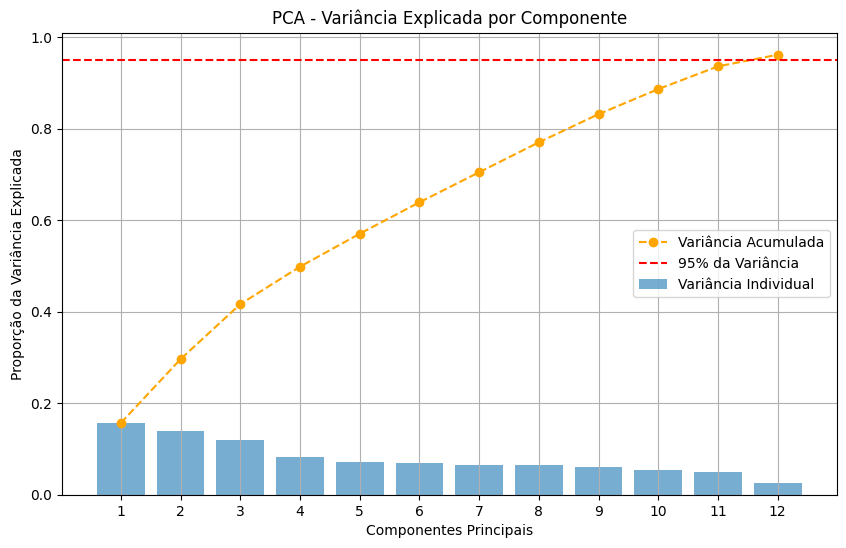

In [38]:
# Aplicando PCA corretamente após a normalização
X_treino_pca, X_teste_pca, modelo_pca = aplicar_pca(X_treino_scaled, X_teste_scaled)

## 7️⃣ Seleção e Modelagem (algoritmos candidatos)

**Modelos escolhidos para teste inicial**:
- Regressão Logística ✅ (simples, interpretável e base de comparação)
- Árvore de Decisão ✅ (bom para identificar variáveis mais importantes)
- Random Forest ✅ (modelo robusto e eficiente)
- XGBoost ✅ (ótimo para classificação e geralmente apresenta bons resultados)

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score

# --- DEFINIÇÃO DOS MODELOS ---
def criar_modelos():
    """
    Retorna um dicionário contendo os modelos de classificação candidatos.
    """
    return {
        'Regressão Logística': LogisticRegression(random_state=1234),
        'Árvore de Decisão': DecisionTreeClassifier(random_state=1234),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=1234),
        'XGBoost': XGBClassifier(eval_metric='logloss', random_state=1234)
    }

### Treinamento e Avaliação de Modelos

In [40]:
# --- FUNÇÃO PARA TREINAMENTO E AVALIAÇÃO ---
def treinar_e_avaliar_modelos_cv(X, y, cv=10):
    """
    Treina e avalia múltiplos modelos de classificação usando validação cruzada (Stratified K-Fold).

    Parâmetros:
    ----------
    X : array-like
        Features do conjunto de dados utilizado para treino e validação.

    y : array-like
        Variável alvo do conjunto de dados.

    cv : int, opcional (padrão=5)
        Número de divisões (folds) para a validação cruzada.

    Retorna:
    -------
    df_resultados : DataFrame
        DataFrame com as médias das métricas de desempenho (Acurácia, Precisão,
        Recall, F1-Score, AUC-ROC) obtidas através da validação cruzada para cada modelo.
        Os modelos são ordenados de forma decrescente pelo valor da AUC-ROC.

    Exemplo de uso:
    ---------------
    >>> df_metricas = treinar_e_avaliar_modelos_cv(X_treino, y_treino, cv=5)
    >>> display(df_metricas)

    Observações:
    ------------
    - Utiliza Stratified K-Fold Cross-Validation para garantir que as proporções
      das classes sejam mantidas em cada divisão.
    - Avalia modelos definidos externamente pela função criar_modelos().
    - As métricas calculadas são:
        - Acurácia (accuracy)
        - Precisão (precision)
        - Recall (recall)
        - F1-Score (f1)
        - Área sob a curva ROC (roc_auc)
    """
    modelos = criar_modelos()
    resultados = {}

    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=1234)

    for nome, modelo in modelos.items():
        print(f"\n🚀 Avaliando modelo: {nome} com Stratified K-Fold Cross-Validation...")

        acuracia = cross_val_score(modelo, X, y, cv=skf, scoring='accuracy').mean()
        precisao = cross_val_score(modelo, X, y, cv=skf, scoring='precision').mean()
        recall = cross_val_score(modelo, X, y, cv=skf, scoring='recall').mean()
        f1 = cross_val_score(modelo, X, y, cv=skf, scoring='f1').mean()
        auc = cross_val_score(modelo, X, y, cv=skf, scoring='roc_auc').mean()

        resultados[nome] = {
            'Acurácia': round(acuracia, 4),
            'Precisão': round(precisao, 4),
            'Recall': round(recall, 4),
            'F1-Score': round(f1, 4),
            'AUC-ROC': round(auc, 4)
        }

    df_resultados = pd.DataFrame(resultados).T.sort_values(by='AUC-ROC', ascending=False)

    print("\n📌 Avaliação com validação cruzada concluída!")
    return df_resultados

In [41]:
# Aplicação validação cruzada no conjunto completo de treino (após pré-processamento e normalização)
df_resultados_cv = treinar_e_avaliar_modelos_cv(X_treino_scaled, y_treino, cv=10)


🚀 Avaliando modelo: Regressão Logística com Stratified K-Fold Cross-Validation...

🚀 Avaliando modelo: Árvore de Decisão com Stratified K-Fold Cross-Validation...

🚀 Avaliando modelo: Random Forest com Stratified K-Fold Cross-Validation...

🚀 Avaliando modelo: XGBoost com Stratified K-Fold Cross-Validation...

📌 Avaliação com validação cruzada concluída!


In [42]:
# Exibição dos resultados
display(df_resultados_cv)

,Acurácia,Precisão,Recall,F1-Score,AUC-ROC
XGBoost,0.9469,0.8590,0.8042,0.8296,0.9795
Random Forest,0.9403,0.8831,0.7266,0.7960,0.9747
Regressão Logística,0.8766,0.6756,0.4478,0.5369,0.8948
Árvore de Decisão,0.9096,0.7155,0.7289,0.7214,0.8366


## 8️⃣ Otimização do XGBoost com RandomizedSearchCV

In [43]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# --- FUNÇÃO PARA OTIMIZAÇÃO DO XGBOOST ---
def otimizar_xgboost(X_treino, y_treino, n_iter=100, cv=10, scoring='roc_auc'):
    """
    Realiza a busca por hiperparâmetros ótimos para XGBoost usando RandomizedSearchCV.

    Parâmetros:
    - X_treino: Conjunto de treino.
    - y_treino: Labels de treino.
    - n_iter: Número de combinações aleatórias de hiperparâmetros (padrão: 10).
    - cv: Número de folds para validação cruzada (padrão: 5).
    - scoring: Métrica de avaliação (padrão: 'roc_auc').

    Retorna:
    - Melhor conjunto de hiperparâmetros encontrados.
    """
    param_dist = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 6, 9],
        'subsample': [0.7, 0.9, 1.0],
        'colsample_bytree': [0.7, 0.9, 1.0],
        'gamma': [0, 0.1, 0.2]
    }

    xgb = XGBClassifier(eval_metric='logloss', random_state=1234)

    random_search = RandomizedSearchCV(
        xgb, param_distributions=param_dist, n_iter=n_iter, scoring=scoring,
        cv=cv, verbose=1, n_jobs=-1, random_state=1234
    )

    random_search.fit(X_treino, y_treino)

    print("\n✅ Melhor combinação de hiperparâmetros:", random_search.best_params_)
    return random_search.best_params_

In [44]:
# Executando otimização do XGBoost
melhores_hiperparametros = otimizar_xgboost(X_treino_scaled, y_treino)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits

✅ Melhor combinação de hiperparâmetros: {'subsample': 0.9, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 0.9}


## Treinando o modelo com os melhores hiperparâmetros

In [45]:
# Criando modelo otimizado
melhor_xgb_final = XGBClassifier(
    **melhores_hiperparametros,
    eval_metric='logloss',
    random_state=1234
)

# Treinando o modelo final
melhor_xgb_final.fit(X_treino_scaled, y_treino)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.2, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=1234, ...)

In [46]:
# Fazendo previsões no conjunto de teste
y_pred_final = melhor_xgb_final.predict(X_teste_scaled)
y_proba_final = melhor_xgb_final.predict_proba(X_teste_scaled)[:, 1]

### Avaliando o desempenho do modelo otimizado

<Figure size 600x500 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


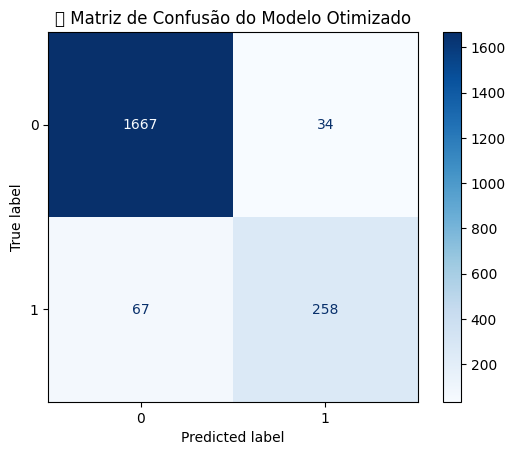

In [47]:
# --- MATRIZ DE CONFUSÃO ---
def exibir_matriz_confusao(y_teste, y_pred):
    """
    Exibe a matriz de confusão formatada.

    Parâmetros:
    - y_teste: Valores reais.
    - y_pred: Previsões do modelo.
    """
    cm = confusion_matrix(y_teste, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)

    plt.figure(figsize=(6, 5))
    disp.plot(cmap='Blues', values_format='d')
    plt.title("📌 Matriz de Confusão do Modelo Otimizado")
    plt.show()

# 🔹 Exibir Matriz de Confusão
exibir_matriz_confusao(y_teste, y_pred_final)

> O modelo tem boa precisão na classificação de clientes adimplentes. Ainda há falsos negativos (inadimplentes classificados como adimplentes), **o que pode ser um problema em estratégias de crédito**.

In [48]:
def exibir_metricas_modelo(y_real, y_pred, y_proba):
    """
    Exibe as métricas detalhadas do modelo.

    Parâmetros:
    - y_real: Valores reais do conjunto de teste.
    - y_pred: Valores previstos pelo modelo.
    - y_proba: Probabilidades previstas pelo modelo para classe positiva.
    """
    report = classification_report(y_real, y_pred, output_dict=True)
    auc = roc_auc_score(y_real, y_proba)

    metricas = {
        'Acurácia': round(report['accuracy'], 4),
        'Precisão': round(report['1']['precision'], 4),
        'Recall': round(report['1']['recall'], 4),
        'F1-Score': round(report['1']['f1-score'], 4),
        'AUC-ROC': round(auc, 4)
    }

    df_metricas = pd.DataFrame([metricas]).T
    df_metricas.columns = ['Modelo Otimizado']

    display(df_metricas)

# 🔹 Exibir métricas detalhadas do modelo otimizado
exibir_metricas_modelo(y_teste, y_pred_final, y_proba_final)

,Modelo Otimizado
Acurácia,0.9501
Precisão,0.8836
Recall,0.7938
F1-Score,0.8363
AUC-ROC,0.9788


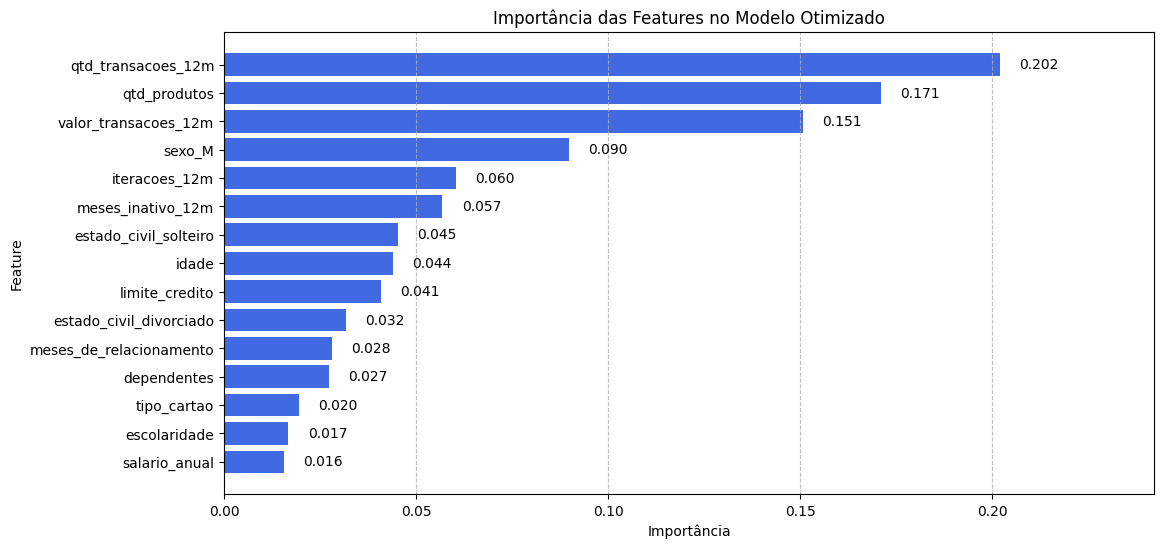

In [49]:
# --- IMPORTÂNCIA DAS FEATURES ---
def plot_importancia_features(modelo, features):
    """
    Plota a importância das features de um modelo treinado.

    Parâmetros:
    - modelo: Modelo treinado do XGBoost.
    - features: Lista com os nomes das features.
    """
    importances = modelo.feature_importances_
    indices = np.argsort(importances)[::-1]  # Ordenar do maior para o menor

    plt.figure(figsize=(12, 6))
    bars = plt.barh(np.array(features)[indices], importances[indices], color='royalblue')

    # Adicionando rótulos dentro das barras
    for bar, importance in zip(bars, importances[indices]):
        plt.text(bar.get_width() + 0.005,  # Garante que o texto fique dentro da área do gráfico
                 bar.get_y() + bar.get_height()/2,
                 f"{importance:.3f}",
                 va='center', ha='left', fontsize=10, color='black')

    plt.grid(axis='x', linestyle='--', alpha=0.8)
    plt.xlabel("Importância")
    plt.ylabel("Feature")
    plt.title("Importância das Features no Modelo Otimizado")
    plt.xlim(0, max(importances) + 0.04)
    plt.gca().invert_yaxis()  # Inverter a ordem para destacar as mais importantes

    plt.show()

# Exibir Importância das Features
plot_importancia_features(melhor_xgb_final, X_treino.columns)

> O comportamento transacional (quantidade e valor de transações) tem um peso maior do que características demográficas (como salário e escolaridade).

> 🔍 Isso sugere que estratégias baseadas no comportamento financeiro recente podem ser mais eficazes para prever inadimplência do que apenas dados cadastrais.

## Feature Engineering

In [50]:
# Recordando o dataframe das features (treino)
X_treino

,idade,dependentes,escolaridade,salario_anual,tipo_cartao,meses_de_relacionamento,qtd_produtos,iteracoes_12m,meses_inativo_12m,limite_credito,valor_transacoes_12m,qtd_transacoes_12m,estado_civil_divorciado,estado_civil_solteiro,sexo_M
3307,41,4,2,4,1,29,4,1,2,12154.32,3853.80,71,0,0,1
3355,51,1,1,3,1,44,4,3,2,4988.82,3890.52,74,0,0,1
6489,44,3,5,4,1,38,5,3,2,19724.58,3830.67,82,0,1,1
8758,50,3,1,1,1,36,2,3,3,5128.28,7588.03,98,0,0,1
8393,44,2,4,1,1,39,2,3,3,4057.91,4301.07,58,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4458,40,3,4,4,1,31,4,3,2,27374.40,4231.26,60,1,0,1
1050,51,1,1,4,1,41,5,3,3,5638.89,2036.30,50,0,0,1
203,47,4,4,3,2,33,3,1,2,34516.23,1060.78,27,0,0,1
1342,52,2,1,4,1,36,3,4,1,22103.39,1541.62,29,0,1,1


In [51]:
# Recordando o dataframe das features (teste)
X_teste

,idade,dependentes,escolaridade,salario_anual,tipo_cartao,meses_de_relacionamento,qtd_produtos,iteracoes_12m,meses_inativo_12m,limite_credito,valor_transacoes_12m,qtd_transacoes_12m,estado_civil_divorciado,estado_civil_solteiro,sexo_M
2266,30,1,4,1,1,19,5,0,2,8744.85,2579.45,68,0,1,1
6483,41,5,2,1,1,34,3,3,1,2137.97,4290.19,90,1,0,0
5976,49,3,4,4,1,45,3,0,2,2453.31,4185.66,66,0,1,1
4055,43,3,4,4,1,33,3,2,3,16351.22,3475.73,82,0,1,1
7818,48,1,4,3,1,38,3,3,3,11367.21,4175.31,63,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3170,53,5,4,4,1,48,6,0,1,9517.10,1453.73,26,0,0,1
2321,36,2,1,3,1,21,4,5,1,12763.96,2599.15,46,0,0,1
7812,42,2,4,1,1,31,2,1,1,3659.13,4068.99,61,0,1,0
2823,50,3,2,1,1,38,4,4,3,1438.18,4740.36,81,0,0,0


In [52]:
# 1. Binning da idade
def binarizar_idade(df):
    df = df.copy()
    df['idade_faixa'] = pd.cut(df['idade'], bins=[18, 30, 40, 50, 60, 70, np.inf],
                               labels=[1, 2, 3, 4, 5, 6])
    return df

X_treino_fe = binarizar_idade(X_treino)
X_teste_fe = binarizar_idade(X_teste)

In [53]:
# 2. Média valor por transação
def media_valor_transacao(df):
    df = df.copy()
    df['media_valor_transacao'] = df['valor_transacoes_12m'] / df['qtd_transacoes_12m'].replace(0, np.nan)
    df['media_valor_transacao'] = df['media_valor_transacao'].fillna(0)
    return df

X_treino_fe = media_valor_transacao(X_treino_fe)
X_teste_fe = media_valor_transacao(X_teste_fe)

In [54]:
# 3. Uso do limite de crédito
def utilizacao_limite_credito(df):
    df = df.copy()
    df['utilizacao_limite_credito'] = df['valor_transacoes_12m'] / df['limite_credito'].replace(0, np.nan)
    return df

X_treino_fe = utilizacao_limite_credito(X_treino_fe)
X_teste_fe = utilizacao_limite_credito(X_teste_fe)

In [55]:
# 4. Binning do tempo de relacionamento
def binarizar_tempo_relacionamento(df):
    df = df.copy()
    df['relacionamento_segmento'] = pd.cut(df['meses_de_relacionamento'],
                                           bins=[0, 24, 36, 48, np.inf],
                                           labels=[1, 2, 3, 4])
    return df

X_treino_fe = binarizar_tempo_relacionamento(X_treino_fe)
X_teste_fe = binarizar_tempo_relacionamento(X_teste_fe)

In [56]:
# 5. Intensidade das interações nos meses ativos
def intensidade_interacoes(df):
    df = df.copy()
    df['intensidade_interacoes'] = df['iteracoes_12m'] / (12 - df['meses_inativo_12m']).replace(0, np.nan)
    df['intensidade_interacoes'] = df['intensidade_interacoes'].fillna(0)
    return df

X_treino_fe = intensidade_interacoes(X_treino_fe)
X_teste_fe = intensidade_interacoes(X_teste_fe)

In [57]:
X_treino_fe

,idade,dependentes,escolaridade,salario_anual,tipo_cartao,meses_de_relacionamento,qtd_produtos,iteracoes_12m,meses_inativo_12m,limite_credito,valor_transacoes_12m,qtd_transacoes_12m,estado_civil_divorciado,estado_civil_solteiro,sexo_M,idade_faixa,media_valor_transacao,utilizacao_limite_credito,relacionamento_segmento,intensidade_interacoes
3307,41,4,2,4,1,29,4,1,2,12154.32,3853.80,71,0,0,1,3,54.278873,0.317072,2,0.100000
3355,51,1,1,3,1,44,4,3,2,4988.82,3890.52,74,0,0,1,4,52.574595,0.779848,3,0.300000
6489,44,3,5,4,1,38,5,3,2,19724.58,3830.67,82,0,1,1,3,46.715488,0.194208,3,0.300000
8758,50,3,1,1,1,36,2,3,3,5128.28,7588.03,98,0,0,1,3,77.428878,1.479644,2,0.333333
8393,44,2,4,1,1,39,2,3,3,4057.91,4301.07,58,0,0,0,3,74.156379,1.059922,3,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4458,40,3,4,4,1,31,4,3,2,27374.40,4231.26,60,1,0,1,2,70.521000,0.154570,2,0.300000
1050,51,1,1,4,1,41,5,3,3,5638.89,2036.30,50,0,0,1,4,40.726000,0.361117,3,0.333333
203,47,4,4,3,2,33,3,1,2,34516.23,1060.78,27,0,0,1,3,39.288148,0.030733,2,0.100000
1342,52,2,1,4,1,36,3,4,1,22103.39,1541.62,29,0,1,1,4,53.159310,0.069746,2,0.363636


In [58]:
X_teste_fe

,idade,dependentes,escolaridade,salario_anual,tipo_cartao,meses_de_relacionamento,qtd_produtos,iteracoes_12m,meses_inativo_12m,limite_credito,valor_transacoes_12m,qtd_transacoes_12m,estado_civil_divorciado,estado_civil_solteiro,sexo_M,idade_faixa,media_valor_transacao,utilizacao_limite_credito,relacionamento_segmento,intensidade_interacoes
2266,30,1,4,1,1,19,5,0,2,8744.85,2579.45,68,0,1,1,1,37.933088,0.294968,1,0.000000
6483,41,5,2,1,1,34,3,3,1,2137.97,4290.19,90,1,0,0,3,47.668778,2.006665,2,0.272727
5976,49,3,4,4,1,45,3,0,2,2453.31,4185.66,66,0,1,1,3,63.419091,1.706128,3,0.000000
4055,43,3,4,4,1,33,3,2,3,16351.22,3475.73,82,0,1,1,3,42.386951,0.212567,2,0.222222
7818,48,1,4,3,1,38,3,3,3,11367.21,4175.31,63,0,1,1,3,66.274762,0.367312,3,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3170,53,5,4,4,1,48,6,0,1,9517.10,1453.73,26,0,0,1,4,55.912692,0.152749,3,0.000000
2321,36,2,1,3,1,21,4,5,1,12763.96,2599.15,46,0,0,1,2,56.503261,0.203632,1,0.454545
7812,42,2,4,1,1,31,2,1,1,3659.13,4068.99,61,0,1,0,3,66.704754,1.112010,2,0.090909
2823,50,3,2,1,1,38,4,4,3,1438.18,4740.36,81,0,0,0,3,58.522963,3.296083,3,0.444444


## Aplicação da modelagem após a criação de novas colunas

In [59]:
# Aplicando normalização
X_treino_scaled_fe, X_teste_scaled_fe, scaler_fe = normalizar_dados(X_treino_fe, X_teste_fe)


✅ Normalização concluída.


In [60]:
# Aplicação validação cruzada no conjunto completo de treino (após pré-processamento e normalização)
df_resultados_cv_fe = treinar_e_avaliar_modelos_cv(X_treino_scaled_fe, y_treino, cv=10)


🚀 Avaliando modelo: Regressão Logística com Stratified K-Fold Cross-Validation...

🚀 Avaliando modelo: Árvore de Decisão com Stratified K-Fold Cross-Validation...

🚀 Avaliando modelo: Random Forest com Stratified K-Fold Cross-Validation...

🚀 Avaliando modelo: XGBoost com Stratified K-Fold Cross-Validation...

📌 Avaliação com validação cruzada concluída!


In [61]:
# Exibição dos resultados
display(df_resultados_cv_fe)

,Acurácia,Precisão,Recall,F1-Score,AUC-ROC
XGBoost,0.9478,0.8708,0.7949,0.8300,0.9789
Random Forest,0.9449,0.8848,0.7588,0.8160,0.9771
Regressão Logística,0.8832,0.7044,0.4747,0.5666,0.9050
Árvore de Decisão,0.9140,0.7297,0.7405,0.7339,0.8438


In [62]:
# Executando otimização do XGBoost
melhores_hiperparametros_fe = otimizar_xgboost(X_treino_scaled_fe, y_treino)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits

✅ Melhor combinação de hiperparâmetros: {'subsample': 0.9, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.9}


In [63]:
# Criando modelo otimizado
melhor_xgb_final_fe = XGBClassifier(
    **melhores_hiperparametros_fe,
    eval_metric='logloss',
    random_state=1234
)

# Treinando o modelo final
melhor_xgb_final_fe.fit(X_treino_scaled_fe, y_treino)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=1234, ...)

In [64]:
# Fazendo previsões no conjunto de teste
y_pred_final_fe = melhor_xgb_final_fe.predict(X_teste_scaled_fe)
y_proba_final_fe = melhor_xgb_final_fe.predict_proba(X_teste_scaled_fe)[:, 1]

<Figure size 600x500 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


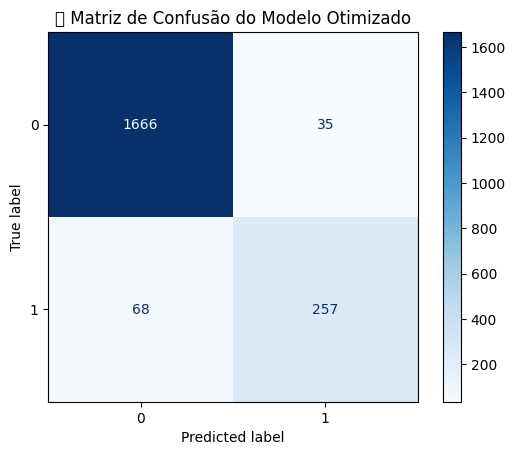

In [65]:
# 🔹 Exibir Matriz de Confusão
exibir_matriz_confusao(y_teste, y_pred_final_fe)

In [66]:
# Exibir métricas detalhadas do modelo otimizado
exibir_metricas_modelo(y_teste, y_pred_final_fe, y_proba_final_fe)

,Modelo Otimizado
Acurácia,0.9492
Precisão,0.8801
Recall,0.7908
F1-Score,0.8331
AUC-ROC,0.9799


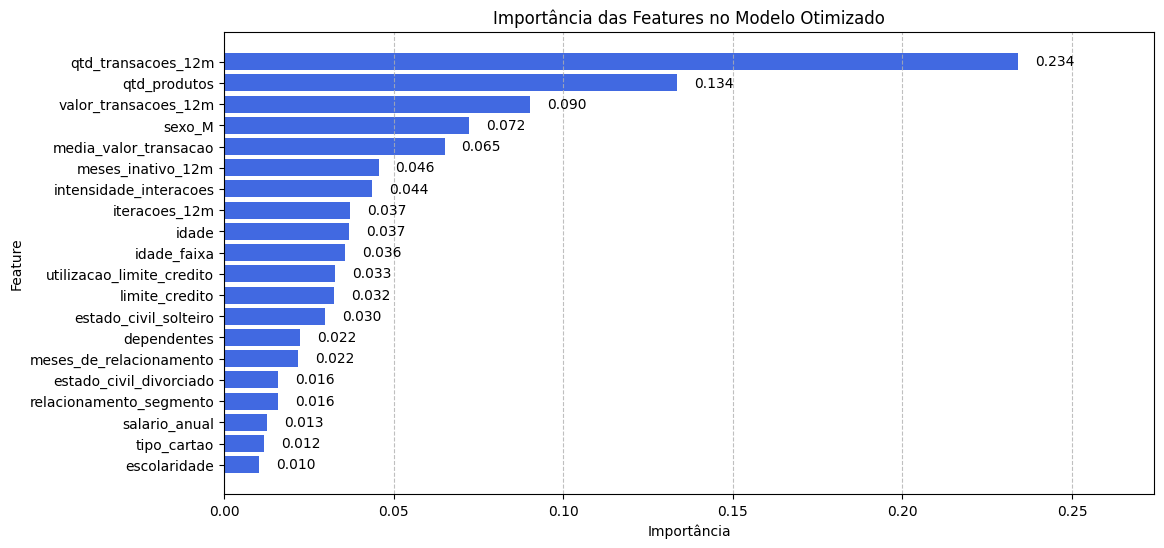

In [68]:
# 🔹 Exibir Importância das Features
plot_importancia_features(melhor_xgb_final_fe, X_treino_fe.columns)